# Mobility data anlaysis (Matt)

In [11]:
# imports and setup
from   ast import literal_eval
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from   scipy.optimize import curve_fit
from   scipy.stats import permutation_test
import seaborn as sns
from   sklearn.preprocessing import LabelBinarizer
import string
import warnings

# locations
data_dir = os.path.join('..', 'data')
derived_dir = os.path.join(data_dir, 'derived')
metadata_dir = os.path.join(data_dir, 'metadata')

conlit_file = 'CONLIT_CharData_AP_MW_11.csv.gz'
early_file  = 'EARLY_CharData_AP_MW_11.csv.gz'

conlit_meta_file = 'CONLIT_META.csv'
early_meta_file = 'EARLY_META.tsv'

## Load data

In [2]:
def string_to_list(x):
    lst = literal_eval(x.replace(', nan', "', ZZZZ'").replace('[nan, ', "'['").replace(', nan]', "']'"))
    return [i for i in lst if i != 'ZZZZ']

# read CONLIT
conlit = pd.read_csv(
    os.path.join(derived_dir, conlit_file), 
    index_col='book_id',
    converters={
        'gpe_places': string_to_list,
        'nongpe_places': string_to_list,
        'all_places': string_to_list,
        'gpe_sequences': string_to_list
    },
)
conlit.replace([np.inf, -np.inf], np.nan, inplace=True)
conlit.rename(columns={'source':'collection'}, inplace=True)
conlit.loc[conlit.inf_gender=='she/her', ['inf_gender']] = 'she/her/hers'

# read EARLY
early = pd.read_csv(
    os.path.join(derived_dir, early_file), 
    index_col='book_id',
    converters={
        'gpe_places': string_to_list,
        'nongpe_places': string_to_list,
        'all_places': string_to_list,
        'gpe_sequences': string_to_list
    },
)
early.replace([np.inf, -np.inf], np.nan, inplace=True)
early.loc[early.inf_gender=='she/her', ['inf_gender']] = 'she/her/hers'

## Calculate new features

In [3]:
early['dist_miles_norm'] = early.dist_miles.div(early.Tokens)
early['dist_miles_norm_byCharacter'] = early.dist_miles.div(early.char_count)
early['perspective'] = early.char_id.apply(lambda x: 'narrator' if x==0 else 'other')
conlit['dist_miles_norm'] = conlit.dist_miles.div(conlit.Tokens)
conlit['dist_miles_norm_byCharacter'] = conlit.dist_miles.div(conlit.char_count)
conlit['perspective'] = conlit.char_id.apply(lambda x: 'narrator' if x==0 else 'other')

## Combine data

Combine EARLY and CONLIT, calculate integrated distance ranks, and write out combined data.

In [4]:
# combine data for easier plotting
data = pd.concat([conlit, early])
data['dist_miles_rank'] = data.dist_miles.rank()
data['non_gpe_total_rank'] = data.nongpe_places_total.rank()
data['gpe_total_rank'] = data.gpe_places_total.rank()
data.to_csv(os.path.join(derived_dir, 'ALL_CharData_AP_MW_11.csv.gz'))

## Feature differences by facet 

### CONLIT

In [5]:
def significance_label(pvalue, levels=[0.05, 0.01, 0.001]):
    if pvalue < levels[2]:
        return '***'
    elif pvalue < levels[1]:
        return '**'
    elif pvalue < levels[0]:
        return '*'
    else: 
        return ''

def diff_means(x, y, axis):
    return np.nanmean(x, axis=axis) - np.nanmean(y, axis=axis)

def compare_facets(df, facets, cols_to_drop, statistic=diff_means):
    '''Compare statistic in numeric cols of df via permutation. Display results, return nothing.'''
    cols = df.select_dtypes(include='number').drop(columns=cols_to_drop).columns
    for facet in facets:
        print(f"\n==============\nFacet: {facet}\n==============")           
        df = df.dropna(subset=[facet])
        if facet == 'inf_gender': # only keep she/her and he/him characters when comparing genders
            df = df.loc[df[facet].isin(set(['she/her/hers', 'he/him/his']))]
        elif facet == 'author_gender':
            df = df.loc[df[facet].isin(set(['F', 'M']))]
            
        if df[facet].nunique() == 2:
            level1, level2 = df[facet].unique()
            data = (df.loc[df[facet]==level1, cols], df.loc[df[facet]==level2, cols])
            level_mean = np.mean(data[0], axis=0)
            other_mean = np.mean(data[1], axis=0)
            output = pd.DataFrame(level_mean, columns=[level1]).join(pd.DataFrame(other_mean, columns=[level2]))
            res = permutation_test(data, statistic, n_resamples=2500)
            output['diff'] = res.statistic
            output['p'] = res.pvalue
            output['sig'] = output['p'].apply(significance_label)
            display(output)            
        else:
            for level in df[facet].unique():
                data = (df.loc[df[facet]==level, cols], df.loc[~(df[facet]==level), cols])
                level_mean = np.mean(data[0], axis=0)
                other_mean = np.mean(data[1], axis=0)
                output = pd.DataFrame(level_mean, columns=[level]).join(pd.DataFrame(other_mean, columns=['others']))
                res = permutation_test(data, statistic, n_resamples=2500)
                output['diff'] = res.statistic
                output['p'] = res.pvalue
                output['sig'] = output['p'].apply(significance_label)
                display(output)

In [6]:
facet_by = ['inf_gender', 'Category', 'Genre', 'author_gender', 'perspective']
ignore_numeric_cols = ['char_id', 'char_rank', 'num_words']
compare_facets(conlit, facet_by, ignore_numeric_cols, diff_means)


Facet: inf_gender


she/her/hers     he/him/his  \
char_count                             3752.279775    4012.726801   
num_gpe_places                           16.356180      22.025360   
num_nongpe_places                       122.757303     127.342939   
num_all_places                          138.620225     148.785591   
dist_miles                            51501.447552   73531.719795   
Tokens                               119516.989888  133472.337752   
num_gpe_places_norm                       0.000141       0.000169   
num_nongpe_places_norm                    0.001127       0.001073   
num_gpe_places_norm_byCharacter           0.005224       0.008396   
num_nongpe_places_norm_byCharacter        0.036178       0.036880   
char_count_norm                           0.034229       0.033202   
nongpe_places_total                     268.564045     273.953314   
gpe_places_total                         52.228090      72.698559   
ttr_nongpe                                0.486012       0.514153   
ttr_gpe                                   0.416419       0.414505   
avg_Distance_GPE                        885.182503     922.925766   
non_gpe_ratio                            13.234252      10.721068   
avg_Distance_GPE_Tokens                   0.434530       0.532501   
deixis_count_perplace                     0.095930       0.087437   
semantic_dist_mean                        0.517677       0.520303   
semantic_dist_total                      89.794573      92.506195   
dist_miles_allChars                  127439.974598  167003.190623   
dist_miles_allChars_norm_Tokens           1.006468       1.163106   
num_gpe_places_allChars_norm_Tokens       0.000411       0.000461   
non_gpe_total_rank                     1478.802247    1371.235159   
dist_miles_rank                        1284.639326    1412.429395   
pub_date                               2013.600000    2013.258790   
Start_Finish_Miles                     1866.066966    1877.179767   
Start_Finish_Z                           -3.871113       0.056328   
first_last_SemanticDist                   0.481413       0.477905   
dist_miles_norm                           0.434530       0.532501   
dist_miles_norm_byCharacter              15.593200      24.490864   

                                             diff         p  sig  
char_count                            -260.447026  0.016793    *  
num_gpe_places                          -5.669180  0.000800  ***  
num_nongpe_places                       -4.585636  0.118353       
num_all_places                         -10.165366  0.005598   **  
dist_miles                          -22030.272244  0.000800  ***  
Tokens                              -13955.347865  0.000800  ***  
num_gpe_places_norm                     -0.000028  0.000800  ***  
num_nongpe_places_norm                   0.000054  0.023990    *  
num_gpe_places_norm_byCharacter         -0.003173  0.000800  ***  
num_nongpe_places_norm_byCharacter      -0.000703  0.286285       
char_count_norm                          0.001027  0.189524       
nongpe_places_total                     -5.389269  0.439824       
gpe_places_total                       -20.470469  0.000800  ***  
ttr_nongpe                              -0.028140  0.000800  ***  
ttr_gpe                                  0.001914  0.806877       
avg_Distance_GPE                       -37.743263  0.194322       
non_gpe_ratio                            2.513184  0.000800  ***  
avg_Distance_GPE_Tokens                 -0.097971  0.000800  ***  
deixis_count_perplace                    0.008493  0.001599   **  
semantic_dist_mean                      -0.002625  0.251899       
semantic_dist_total                     -2.711623  0.261495       
dist_miles_allChars                 -39563.216025  0.000800  ***  
dist_miles_allChars_norm_Tokens         -0.156638  0.003199   **  
num_gpe_places_allChars_norm_Tokens     -0.000049  0.000800  ***  
non_gpe_total_rank                     107.567089  0.002399   **  
dist_miles_rank   


Facet: Category


FIC            NON  \
char_count                             4206.913721    3149.084165   
num_gpe_places                           13.303015      38.767475   
num_nongpe_places                       123.844595     131.122682   
num_all_places                          136.735447     168.952924   
dist_miles                            37960.992737  143190.973096   
Tokens                               121735.203742  147968.751783   
num_gpe_places_norm                       0.000117       0.000277   
num_nongpe_places_norm                    0.001115       0.001026   
num_gpe_places_norm_byCharacter           0.003793       0.017004   
num_nongpe_places_norm_byCharacter        0.033240       0.045981   
char_count_norm                           0.036996       0.024093   
nongpe_places_total                     275.656965     262.435093   
gpe_places_total                         38.843555     139.629101   
ttr_nongpe                                0.482953       0.564058   
ttr_gpe                                   0.433978       0.363488   
avg_Distance_GPE                        867.090881    1028.253605   
non_gpe_ratio                            14.362728       4.034508   
avg_Distance_GPE_Tokens                   0.326562       0.973346   
deixis_count_perplace                     0.109287       0.038250   
semantic_dist_mean                        0.521810       0.512832   
semantic_dist_total                      91.535458      91.727813   
dist_miles_allChars                   91807.710668  323158.456202   
dist_miles_allChars_norm_Tokens           0.755746       2.082296   
num_gpe_places_allChars_norm_Tokens       0.000343       0.000720   
non_gpe_total_rank                     1493.128898    1173.248217   
dist_miles_rank                        1172.623701    1908.368046   
pub_date                               2013.473493    2013.102710   
Start_Finish_Miles                     1850.113982    1937.356911   
Start_Finish_Z                           -1.604259      -0.375842   
first_last_SemanticDist                   0.491380       0.448460   
dist_miles_norm                           0.326562       0.973346   
dist_miles_norm_byCharacter              10.065070      52.788021   

                                              diff         p  sig  
char_count                             1057.829556  0.000800  ***  
num_gpe_places                          -25.464460  0.000800  ***  
num_nongpe_places                        -7.278087  0.019192    *  
num_all_places                          -32.217477  0.000800  ***  
dist_miles                          -105229.980359  0.000800  ***  
Tokens                               -26233.548041  0.000800  ***  
num_gpe_places_norm                      -0.000160  0.000800  ***  
num_nongpe_places_norm                    0.000089  0.001599   **  
num_gpe_places_norm_byCharacter          -0.013212  0.000800  ***  
num_nongpe_places_norm_byCharacter       -0.012741  0.000800  ***  
char_count_norm                           0.012903  0.000800  ***  
nongpe_places_total                      13.221872  0.099160       
gpe_places_total                       -100.785546  0.000800  ***  
ttr_nongpe                               -0.081105  0.000800  ***  
ttr_gpe                                   0.070490  0.000800  ***  
avg_Distance_GPE                       -161.162724  0.000800  ***  
non_gpe_ratio                            10.328220  0.000800  ***  
avg_Distance_GPE_Tokens                  -0.646784  0.000800  ***  
deixis_count_perplace                     0.071037  0.000800  ***  
semantic_dist_mean                        0.008979  0.001599   **  
semantic_dist_total                      -0.192354  0.979608       
dist_miles_allChars                 -231350.745534  0.000800  ***  
dist_miles_allChars_norm_Tokens          -1.326549  0.000800  ***  
num_gpe_places_allChars_norm_Tokens      -0.000377  0.000800  ***  
non_gpe_total_rank                      319.880681  0.000800  ***  
d


Facet: Genre


YA         others  \
char_count                             5664.129944    3798.635212   
num_gpe_places                           11.519774      20.723856   
num_nongpe_places                       130.824859     125.424020   
num_all_places                          141.903955     145.587418   
dist_miles                            28737.615271   68761.137362   
Tokens                               106057.067797  130380.933824   
num_gpe_places_norm                       0.000113       0.000163   
num_nongpe_places_norm                    0.001257       0.001079   
num_gpe_places_norm_byCharacter           0.002359       0.007679   
num_nongpe_places_norm_byCharacter        0.024377       0.037529   
char_count_norm                           0.053540       0.032105   
nongpe_places_total                     330.276836     267.921569   
gpe_places_total                         36.039548      67.906863   
ttr_nongpe                                0.414748       0.511109   
ttr_gpe                                   0.397822       0.416407   
avg_Distance_GPE                        726.161437     923.430579   
non_gpe_ratio                            16.972565      11.182647   
avg_Distance_GPE_Tokens                   0.286742       0.514652   
deixis_count_perplace                     0.131705       0.087324   
semantic_dist_mean                        0.501767       0.520688   
semantic_dist_total                     101.196706      90.891994   
dist_miles_allChars                   59808.051991  160370.133955   
dist_miles_allChars_norm_Tokens           0.591521       1.147486   
num_gpe_places_allChars_norm_Tokens       0.000301       0.000454   
non_gpe_total_rank                     1951.581921    1368.381127   
dist_miles_rank                        1149.841808    1384.955882   
pub_date                               2014.949153    2013.260621   
Start_Finish_Miles                     1428.657398    1905.569500   
Start_Finish_Z                           -0.755748      -1.306270   
first_last_SemanticDist                   0.516607       0.476330   
dist_miles_norm                           0.286742       0.514652   
dist_miles_norm_byCharacter               6.013972      22.591963   

                                              diff         p  sig  
char_count                             1865.494731  0.000800  ***  
num_gpe_places                           -9.204082  0.000800  ***  
num_nongpe_places                         5.400839  0.356657       
num_all_places                           -3.683463  0.573371       
dist_miles                           -40023.522092  0.000800  ***  
Tokens                               -24323.866027  0.000800  ***  
num_gpe_places_norm                      -0.000050  0.000800  ***  
num_nongpe_places_norm                    0.000178  0.000800  ***  
num_gpe_places_norm_byCharacter          -0.005320  0.000800  ***  
num_nongpe_places_norm_byCharacter       -0.013152  0.000800  ***  
char_count_norm                           0.021435  0.000800  ***  
nongpe_places_total                      62.355268  0.000800  ***  
gpe_places_total                        -31.867315  0.000800  ***  
ttr_nongpe                               -0.096361  0.000800  ***  
ttr_gpe                                  -0.018585  0.222311       
avg_Distance_GPE                       -197.269142  0.000800  ***  
non_gpe_ratio                             5.789918  0.000800  ***  
avg_Distance_GPE_Tokens                  -0.227910  0.000800  ***  
deixis_count_perplace                     0.044381  0.000800  ***  
semantic_dist_mean                       -0.018921  0.000800  ***  
semantic_dist_total                      10.304712  0.036785    *  
dist_miles_allChars                 -100562.081964  0.000800  ***  
dist_miles_allChars_norm_Tokens          -0.555965  0.000800  ***  
num_gpe_places_allChars_norm_Tokens      -0.000153  0.000800  ***  
non_gpe_total_rank                      583.200793  0.000800  ***  
di

SF         others  \
char_count                             3816.963303    3934.155380   
num_gpe_places                           12.559633      20.786456   
num_nongpe_places                       114.935780     126.771084   
num_all_places                          126.899083     147.009140   
dist_miles                            30941.681274   69243.263668   
Tokens                               144582.059633  127306.081429   
num_gpe_places_norm                       0.000097       0.000165   
num_nongpe_places_norm                    0.000889       0.001109   
num_gpe_places_norm_byCharacter           0.003720       0.007647   
num_nongpe_places_norm_byCharacter        0.031726       0.037087   
char_count_norm                           0.029121       0.033952   
nongpe_places_total                     232.545872     275.710843   
gpe_places_total                         34.119266      68.623598   
ttr_nongpe                                0.528479       0.502450   
ttr_gpe                                   0.454952       0.411549   
avg_Distance_GPE                        800.336282     920.072838   
non_gpe_ratio                            13.996746      11.351183   
avg_Distance_GPE_Tokens                   0.240555       0.522717   
deixis_count_perplace                     0.112552       0.088303   
semantic_dist_mean                        0.547676       0.516853   
semantic_dist_total                      82.904059      92.373217   
dist_miles_allChars                   75814.526143  160633.380317   
dist_miles_allChars_norm_Tokens           0.552357       1.160503   
num_gpe_places_allChars_norm_Tokens       0.000277       0.000459   
non_gpe_total_rank                     1109.573394    1434.707104   
dist_miles_rank                         955.743119    1406.540091   
pub_date                               2012.940367    2013.413793   
Start_Finish_Miles                     2269.024192    1837.581729   
Start_Finish_Z                           -0.685420      -1.319887   
first_last_SemanticDist                   0.533554       0.474715   
dist_miles_norm                           0.240555       0.522717   
dist_miles_norm_byCharacter               8.563491      22.643438   

                                             diff         p  sig  
char_count                            -117.192077  0.553379       
num_gpe_places                          -8.226823  0.000800  ***  
num_nongpe_places                      -11.835305  0.024790    *  
num_all_places                         -20.110057  0.001599   **  
dist_miles                          -38301.582393  0.000800  ***  
Tokens                               17275.978204  0.000800  ***  
num_gpe_places_norm                     -0.000069  0.000800  ***  
num_nongpe_places_norm                  -0.000220  0.000800  ***  
num_gpe_places_norm_byCharacter         -0.003927  0.000800  ***  
num_nongpe_places_norm_byCharacter      -0.005361  0.000800  ***  
char_count_norm                         -0.004831  0.002399   **  
nongpe_places_total                    -43.164972  0.003199   **  
gpe_places_total                       -34.504332  0.000800  ***  
ttr_nongpe                               0.026028  0.003199   **  
ttr_gpe                                  0.043402  0.003199   **  
avg_Distance_GPE                      -119.736556  0.007997   **  
non_gpe_ratio                            2.645563  0.011995    *  
avg_Distance_GPE_Tokens                 -0.282162  0.000800  ***  
deixis_count_perplace                    0.024249  0.000800  ***  
semantic_dist_mean                       0.030823  0.000800  ***  
semantic_dist_total                     -9.469158  0.027989    *  
dist_miles_allChars                 -84818.854174  0.000800  ***  
dist_miles_allChars_norm_Tokens         -0.608147  0.000800  ***  
num_gpe_places_allChars_norm_Tokens     -0.000182  0.000800  ***  
non_gpe_total_rank                    -325.133710  0.000800  ***  
dist_miles_rank             

BS         others  \
char_count                             4732.879032    3840.074043   
num_gpe_places                           17.459677      20.379049   
num_nongpe_places                       143.322581     123.958772   
num_all_places                          160.282258     143.779975   
dist_miles                            48957.187351   67847.050779   
Tokens                               155174.580645  125982.890618   
num_gpe_places_norm                       0.000125       0.000163   
num_nongpe_places_norm                    0.001016       0.001099   
num_gpe_places_norm_byCharacter           0.004558       0.007609   
num_nongpe_places_norm_byCharacter        0.034952       0.036819   
char_count_norm                           0.031016       0.033815   
nongpe_places_total                     311.072581     268.062684   
gpe_places_total                         50.020161      67.400084   
ttr_nongpe                                0.499054       0.505192   
ttr_gpe                                   0.439863       0.412576   
avg_Distance_GPE                        938.972800     907.119637   
non_gpe_ratio                            10.622966      11.672256   
avg_Distance_GPE_Tokens                   0.339223       0.515984   
deixis_count_perplace                     0.108939       0.088374   
semantic_dist_mean                        0.519814       0.519371   
semantic_dist_total                     105.492714      90.135980   
dist_miles_allChars                  126305.203528  156436.021308   
dist_miles_allChars_norm_Tokens           0.850054       1.137119   
num_gpe_places_allChars_norm_Tokens       0.000395       0.000449   
non_gpe_total_rank                     1332.032258    1415.600757   
dist_miles_rank                        1273.657258    1379.060581   
pub_date                               2011.790323    2013.539756   
Start_Finish_Miles                     1868.137934    1873.962259   
Start_Finish_Z                           -1.000769      -1.297495   
first_last_SemanticDist                   0.480895       0.478891   
dist_miles_norm                           0.339223       0.515984   
dist_miles_norm_byCharacter              11.636333      22.500541   

                                             diff         p  sig  
char_count                             892.804989  0.001599   **  
num_gpe_places                          -2.919372  0.030388    *  
num_nongpe_places                       19.363809  0.000800  ***  
num_all_places                          16.502283  0.006397   **  
dist_miles                          -18889.863428  0.002399   **  
Tokens                               29191.690027  0.000800  ***  
num_gpe_places_norm                     -0.000038  0.000800  ***  
num_nongpe_places_norm                  -0.000083  0.025590    *  
num_gpe_places_norm_byCharacter         -0.003051  0.000800  ***  
num_nongpe_places_norm_byCharacter      -0.001867  0.081567       
char_count_norm                         -0.002799  0.025590    *  
nongpe_places_total                     43.009897  0.001599   **  
gpe_places_total                       -17.379923  0.000800  ***  
ttr_nongpe                              -0.006138  0.443822       
ttr_gpe                                  0.027287  0.039184    *  
avg_Distance_GPE                        31.853163  0.529388       
non_gpe_ratio                           -1.049290  0.247101       
avg_Distance_GPE_Tokens                 -0.176760  0.000800  ***  
deixis_count_perplace                    0.020566  0.000800  ***  
semantic_dist_mean                       0.000444  0.932427       
semantic_dist_total                     15.356734  0.000800  ***  
dist_miles_allChars                 -30130.817780  0.026389    *  
dist_miles_allChars_norm_Tokens         -0.287065  0.000800  ***  
num_gpe_places_allChars_norm_Tokens     -0.000054  0.003998   **  
non_gpe_total_rank                     -83.568499  0.091963       
dist_miles_rank             

NYT         others  \
char_count                             3719.703349    3963.196194   
num_gpe_places                           16.351675      20.813774   
num_nongpe_places                       129.624402     125.061622   
num_all_places                          145.581340     145.293158   
dist_miles                            52104.402460   68706.018096   
Tokens                               118268.789474  130724.183507   
num_gpe_places_norm                       0.000150       0.000161   
num_nongpe_places_norm                    0.001194       0.001072   
num_gpe_places_norm_byCharacter           0.004899       0.007779   
num_nongpe_places_norm_byCharacter        0.037954       0.036394   
char_count_norm                           0.032846       0.033684   
nongpe_places_total                     282.799043     270.104667   
gpe_places_total                         48.894737      68.951971   
ttr_nongpe                                0.494136       0.506596   
ttr_gpe                                   0.427841       0.412751   
avg_Distance_GPE                        962.235994     900.260075   
non_gpe_ratio                            12.343310      11.424714   
avg_Distance_GPE_Tokens                   0.460166       0.506693   
deixis_count_perplace                     0.092939       0.089820   
semantic_dist_mean                        0.530297       0.517351   
semantic_dist_total                      96.897805      90.580941   
dist_miles_allChars                  122780.156301  159424.561753   
dist_miles_allChars_norm_Tokens           1.065603       1.118406   
num_gpe_places_allChars_norm_Tokens       0.000433       0.000446   
non_gpe_total_rank                     1513.921053    1387.588582   
dist_miles_rank                        1416.016746    1360.217037   
pub_date                               2014.949761    2013.076121   
Start_Finish_Miles                     1973.131090    1854.525465   
Start_Finish_Z                           -1.556370      -1.215266   
first_last_SemanticDist                   0.502103       0.474732   
dist_miles_norm                           0.460166       0.506693   
dist_miles_norm_byCharacter              14.317249      22.829627   

                                             diff         p  sig  
char_count                            -243.492845  0.086365       
num_gpe_places                          -4.462100  0.000800  ***  
num_nongpe_places                        4.562780  0.251100       
num_all_places                           0.288182  0.971611       
dist_miles                          -16601.615636  0.005598   **  
Tokens                              -12455.394033  0.000800  ***  
num_gpe_places_norm                     -0.000011  0.130348       
num_nongpe_places_norm                   0.000122  0.000800  ***  
num_gpe_places_norm_byCharacter         -0.002880  0.000800  ***  
num_nongpe_places_norm_byCharacter       0.001560  0.088764       
char_count_norm                         -0.000837  0.412635       
nongpe_places_total                     12.694376  0.187925       
gpe_places_total                       -20.057234  0.000800  ***  
ttr_nongpe                              -0.012460  0.045582    *  
ttr_gpe                                  0.015091  0.147141       
avg_Distance_GPE                        61.975920  0.104758       
non_gpe_ratio                            0.918596  0.211116       
avg_Distance_GPE_Tokens                 -0.046527  0.207117       
deixis_count_perplace                    0.003119  0.391843       
semantic_dist_mean                       0.012946  0.000800  ***  
semantic_dist_total                      6.316865  0.058377       
dist_miles_allChars                 -36644.405452  0.005598   **  
dist_miles_allChars_norm_Tokens         -0.052804  0.427029       
num_gpe_places_allChars_norm_Tokens     -0.000013  0.419832       
non_gpe_total_rank                     126.332471  0.002399   **  
dist_miles_rank            

MY         others  \
char_count                             4099.149573    3907.322877   
num_gpe_places                           13.286325      20.770389   
num_nongpe_places                       132.316239     125.149310   
num_all_places                          145.226496     145.350063   
dist_miles                            33531.764764   69246.084990   
Tokens                               124630.961538  129143.028858   
num_gpe_places_norm                       0.000109       0.000165   
num_nongpe_places_norm                    0.001113       0.001089   
num_gpe_places_norm_byCharacter           0.003733       0.007672   
num_nongpe_places_norm_byCharacter        0.034180       0.036883   
char_count_norm                           0.034501       0.033457   
nongpe_places_total                     291.196581     270.259724   
gpe_places_total                         34.991453      68.769134   
ttr_nongpe                                0.485378       0.506494   
ttr_gpe                                   0.447440       0.411994   
avg_Distance_GPE                        948.430830     906.380517   
non_gpe_ratio                            12.959938      11.435349   
avg_Distance_GPE_Tokens                   0.273385       0.521392   
deixis_count_perplace                     0.116840       0.087721   
semantic_dist_mean                        0.518581       0.519494   
semantic_dist_total                      97.253731      91.032223   
dist_miles_allChars                   88708.077572  159939.114584   
dist_miles_allChars_norm_Tokens           0.693834       1.150727   
num_gpe_places_allChars_norm_Tokens       0.000342       0.000454   
non_gpe_total_rank                     1501.128205    1398.562526   
dist_miles_rank                        1186.914530    1386.932664   
pub_date                               2013.927350    2013.320368   
Start_Finish_Miles                     1821.244257    1878.517499   
Start_Finish_Z                           -3.168317      -1.080606   
first_last_SemanticDist                   0.481514       0.478839   
dist_miles_norm                           0.273385       0.521392   
dist_miles_norm_byCharacter               9.181511      22.677174   

                                             diff         p  sig  
char_count                             191.826695  0.274290       
num_gpe_places                          -7.484064  0.000800  ***  
num_nongpe_places                        7.166929  0.157537       
num_all_places                          -0.123567  0.989204       
dist_miles                          -35714.320226  0.000800  ***  
Tokens                               -4512.067320  0.343063       
num_gpe_places_norm                     -0.000056  0.000800  ***  
num_nongpe_places_norm                   0.000025  0.514194       
num_gpe_places_norm_byCharacter         -0.003938  0.000800  ***  
num_nongpe_places_norm_byCharacter      -0.002703  0.015994    *  
char_count_norm                          0.001044  0.403838       
nongpe_places_total                     20.936857  0.089564       
gpe_places_total                       -33.777681  0.000800  ***  
ttr_nongpe                              -0.021116  0.009596   **  
ttr_gpe                                  0.035446  0.007997   **  
avg_Distance_GPE                        42.050313  0.367853       
non_gpe_ratio                            1.524589  0.138345       
avg_Distance_GPE_Tokens                 -0.248007  0.000800  ***  
deixis_count_perplace                    0.029119  0.000800  ***  
semantic_dist_mean                      -0.000913  0.785286       
semantic_dist_total                      6.221508  0.136745       
dist_miles_allChars                 -71231.037013  0.000800  ***  
dist_miles_allChars_norm_Tokens         -0.456892  0.000800  ***  
num_gpe_places_allChars_norm_Tokens     -0.000112  0.000800  ***  
non_gpe_total_rank                     102.565679  0.056777       
dist_miles_rank             

ROM         others  \
char_count                             5970.480769    3748.345056   
num_gpe_places                            7.625000      21.177079   
num_nongpe_places                       108.990385     127.233761   
num_all_places                          116.403846     147.829127   
dist_miles                            20950.401077   69944.616774   
Tokens                               103573.639423  130906.623914   
num_gpe_places_norm                       0.000075       0.000167   
num_nongpe_places_norm                    0.001099       0.001090   
num_gpe_places_norm_byCharacter           0.001397       0.007830   
num_nongpe_places_norm_byCharacter        0.019871       0.038085   
char_count_norm                           0.058572       0.031397   
nongpe_places_total                     272.336538     272.107985   
gpe_places_total                         24.841346      69.279272   
ttr_nongpe                                0.420773       0.511827   
ttr_gpe                                   0.392064       0.417141   
avg_Distance_GPE                        662.768489     931.416130   
non_gpe_ratio                            20.463774      10.843184   
avg_Distance_GPE_Tokens                   0.195665       0.525413   
deixis_count_perplace                     0.147241       0.085418   
semantic_dist_mean                        0.484014       0.522459   
semantic_dist_total                      77.688610      92.782866   
dist_miles_allChars                   43729.029247  163043.638825   
dist_miles_allChars_norm_Tokens           0.401260       1.170990   
num_gpe_places_allChars_norm_Tokens       0.000201       0.000465   
non_gpe_total_rank                     1693.024038    1383.151841   
dist_miles_rank                         901.360577    1409.354986   
pub_date                               2014.389423    2013.287133   
Start_Finish_Miles                     1643.127581    1893.229607   
Start_Finish_Z                           -1.219840      -1.273451   
first_last_SemanticDist                   0.456011       0.480956   
dist_miles_norm                           0.195665       0.525413   
dist_miles_norm_byCharacter               3.568745      23.015018   

                                              diff         p  sig  
char_count                             2222.135713  0.000800  ***  
num_gpe_places                          -13.552079  0.000800  ***  
num_nongpe_places                       -18.243376  0.000800  ***  
num_all_places                          -31.425281  0.000800  ***  
dist_miles                           -48994.215697  0.000800  ***  
Tokens                               -27332.984491  0.000800  ***  
num_gpe_places_norm                      -0.000092  0.000800  ***  
num_nongpe_places_norm                    0.000009  0.840464       
num_gpe_places_norm_byCharacter          -0.006434  0.000800  ***  
num_nongpe_places_norm_byCharacter       -0.018214  0.000800  ***  
char_count_norm                           0.027175  0.000800  ***  
nongpe_places_total                       0.228553  0.954018       
gpe_places_total                        -44.437926  0.000800  ***  
ttr_nongpe                               -0.091054  0.000800  ***  
ttr_gpe                                  -0.025077  0.074370       
avg_Distance_GPE                       -268.647641  0.000800  ***  
non_gpe_ratio                             9.620590  0.000800  ***  
avg_Distance_GPE_Tokens                  -0.329748  0.000800  ***  
deixis_count_perplace                     0.061823  0.000800  ***  
semantic_dist_mean                       -0.038445  0.000800  ***  
semantic_dist_total                     -15.094256  0.000800  ***  
dist_miles_allChars                 -119314.609578  0.000800  ***  
dist_miles_allChars_norm_Tokens          -0.769730  0.000800  ***  
num_gpe_places_allChars_norm_Tokens      -0.000264  0.000800  ***  
non_gpe_total_rank                      309.872197  0.000800  ***  
d

HIST         others  \
char_count                             1108.458824    4119.418330   
num_gpe_places                           21.782353      19.986965   
num_nongpe_places                        52.535294     130.860692   
num_all_places                           73.958824     150.281874   
dist_miles                            61414.269996   66384.275465   
Tokens                               150749.582353  127216.781263   
num_gpe_places_norm                       0.000158       0.000160   
num_nongpe_places_norm                    0.000377       0.001141   
num_gpe_places_norm_byCharacter           0.026123       0.006019   
num_nongpe_places_norm_byCharacter        0.049042       0.035783   
char_count_norm                           0.007756       0.035337   
nongpe_places_total                      90.111765     284.729939   
gpe_places_total                         64.894118      65.817923   
ttr_nongpe                                0.651510       0.494440   
ttr_gpe                                   0.434789       0.413794   
avg_Distance_GPE                       1021.334473     902.428420   
non_gpe_ratio                             2.417433      12.211913   
avg_Distance_GPE_Tokens                   0.428052       0.504217   
deixis_count_perplace                     0.024126       0.094900   
semantic_dist_mean                        0.509209       0.520119   
semantic_dist_total                      33.908883      95.580818   
dist_miles_allChars                  246278.398240  147170.992025   
dist_miles_allChars_norm_Tokens           1.678488       1.070632   
num_gpe_places_allChars_norm_Tokens       0.000665       0.000429   
non_gpe_total_rank                      378.547059    1478.971079   
dist_miles_rank                        1416.947059    1365.789409   
pub_date                               2013.635294    2013.356415   
Start_Finish_Miles                     1730.497094    1883.308346   
Start_Finish_Z                           -0.315793      -1.337099   
first_last_SemanticDist                   0.425073       0.483073   
dist_miles_norm                           0.428052       0.504217   
dist_miles_norm_byCharacter              64.085104      18.523474   

                                             diff         p  sig  
char_count                           -3010.959506  0.000800  ***  
num_gpe_places                           1.795388  0.286285       
num_nongpe_places                      -78.325398  0.000800  ***  
num_all_places                         -76.323050  0.000800  ***  
dist_miles                           -4970.005469  0.619752       
Tokens                               23532.801090  0.000800  ***  
num_gpe_places_norm                     -0.000002  0.896441       
num_nongpe_places_norm                  -0.000764  0.000800  ***  
num_gpe_places_norm_byCharacter          0.020105  0.000800  ***  
num_nongpe_places_norm_byCharacter       0.013259  0.000800  ***  
char_count_norm                         -0.027581  0.000800  ***  
nongpe_places_total                   -194.618174  0.000800  ***  
gpe_places_total                        -0.923805  0.953219       
ttr_nongpe                               0.157070  0.000800  ***  
ttr_gpe                                  0.020995  0.183127       
avg_Distance_GPE                       118.906054  0.032787    *  
non_gpe_ratio                           -9.794481  0.000800  ***  
avg_Distance_GPE_Tokens                 -0.076165  0.173531       
deixis_count_perplace                   -0.070774  0.000800  ***  
semantic_dist_mean                      -0.010910  0.016793    *  
semantic_dist_total                    -61.671935  0.000800  ***  
dist_miles_allChars                  99107.406214  0.000800  ***  
dist_miles_allChars_norm_Tokens          0.607855  0.000800  ***  
num_gpe_places_allChars_norm_Tokens      0.000237  0.000800  ***  
non_gpe_total_rank                   -1100.424021  0.000800  ***  
dist_miles_rank           

PW         others  \
char_count                             3185.085938    4004.317434   
num_gpe_places                           14.812500      20.674968   
num_nongpe_places                       121.613281     126.239341   
num_all_places                          135.976562     146.350781   
dist_miles                            49134.962572   67891.630117   
Tokens                               122486.812500  129416.632756   
num_gpe_places_norm                       0.000134       0.000162   
num_nongpe_places_norm                    0.001108       0.001089   
num_gpe_places_norm_byCharacter           0.005177       0.007552   
num_nongpe_places_norm_byCharacter        0.042256       0.036035   
char_count_norm                           0.027561       0.034198   
nongpe_places_total                     259.597656     273.479949   
gpe_places_total                         42.367188      68.285775   
ttr_nongpe                                0.509417       0.504092   
ttr_gpe                                   0.462003       0.410091   
avg_Distance_GPE                       1021.589771     898.084276   
non_gpe_ratio                            12.142340      11.509986   
avg_Distance_GPE_Tokens                   0.442658       0.505403   
deixis_count_perplace                     0.087726       0.090596   
semantic_dist_mean                        0.531394       0.518118   
semantic_dist_total                      89.547556      91.807195   
dist_miles_allChars                  121557.580231  157050.811559   
dist_miles_allChars_norm_Tokens           1.010014       1.120803   
num_gpe_places_allChars_norm_Tokens       0.000396       0.000449   
non_gpe_total_rank                     1368.582031    1411.933305   
dist_miles_rank                        1325.539062    1373.810046   
pub_date                               2010.671875    2013.666526   
Start_Finish_Miles                     2152.926079    1843.207016   
Start_Finish_Z                           -0.500114      -1.352324   
first_last_SemanticDist                   0.487425       0.478201   
dist_miles_norm                           0.442658       0.505403   
dist_miles_norm_byCharacter              15.056938      22.167590   

                                             diff         p  sig  
char_count                            -819.231496  0.000800  ***  
num_gpe_places                          -5.862468  0.000800  ***  
num_nongpe_places                       -4.626060  0.336665       
num_all_places                         -10.374218  0.068772       
dist_miles                          -18756.667545  0.003998   **  
Tokens                               -6929.820256  0.106357       
num_gpe_places_norm                     -0.000028  0.000800  ***  
num_nongpe_places_norm                   0.000018  0.643743       
num_gpe_places_norm_byCharacter         -0.002375  0.000800  ***  
num_nongpe_places_norm_byCharacter       0.006221  0.000800  ***  
char_count_norm                         -0.006636  0.000800  ***  
nongpe_places_total                    -13.882293  0.234306       
gpe_places_total                       -25.918587  0.000800  ***  
ttr_nongpe                               0.005325  0.488605       
ttr_gpe                                  0.051912  0.000800  ***  
avg_Distance_GPE                       123.505495  0.008796   **  
non_gpe_ratio                            0.632353  0.478209       
avg_Distance_GPE_Tokens                 -0.062746  0.163934       
deixis_count_perplace                   -0.002870  0.499800       
semantic_dist_mean                       0.013276  0.000800  ***  
semantic_dist_total                     -2.259639  0.578169       
dist_miles_allChars                 -35493.231328  0.007997   **  
dist_miles_allChars_norm_Tokens         -0.110789  0.176729       
num_gpe_places_allChars_norm_Tokens     -0.000053  0.008796   **  
non_gpe_total_rank                     -43.351274  0.395042       
dist_miles_rank             

MIX         others  \
char_count                             2173.366906    4022.329847   
num_gpe_places                           30.064748      19.546259   
num_nongpe_places                       101.244604     127.160499   
num_all_places                          130.611511     146.162510   
dist_miles                           119378.998284   63081.311908   
Tokens                               133051.043165  128499.811746   
num_gpe_places_norm                       0.000232       0.000156   
num_nongpe_places_norm                    0.000867       0.001104   
num_gpe_places_norm_byCharacter           0.017955       0.006726   
num_nongpe_places_norm_byCharacter        0.048987       0.035952   
char_count_norm                           0.018479       0.034393   
nongpe_places_total                     195.280576     276.422767   
gpe_places_total                        104.079137      63.615447   
ttr_nongpe                                0.585664       0.500080   
ttr_gpe                                   0.406584       0.415633   
avg_Distance_GPE                       1036.577018     903.058900   
non_gpe_ratio                             4.099900      11.996351   
avg_Distance_GPE_Tokens                   0.825041       0.481070   
deixis_count_perplace                     0.038847       0.093194   
semantic_dist_mean                        0.499415       0.520531   
semantic_dist_total                      68.500095      92.877677   
dist_miles_allChars                  273499.543946  146884.825629   
dist_miles_allChars_norm_Tokens           1.777701       1.072665   
num_gpe_places_allChars_norm_Tokens       0.000627       0.000434   
non_gpe_total_rank                      945.086331    1433.572003   
dist_miles_rank                        1737.266187    1348.517297   
pub_date                               2011.352518    2013.487530   
Start_Finish_Miles                     1918.905468    1870.868317   
Start_Finish_Z                           -0.130255      -1.333583   
first_last_SemanticDist                   0.426173       0.482210   
dist_miles_norm                           0.825041       0.481070   
dist_miles_norm_byCharacter              56.727359      19.503015   

                                              diff         p  sig  
char_count                            -1848.962941  0.000800  ***  
num_gpe_places                           10.518489  0.000800  ***  
num_nongpe_places                       -25.915894  0.000800  ***  
num_all_places                          -15.550999  0.037585    *  
dist_miles                            56297.686376  0.000800  ***  
Tokens                                 4551.231420  0.447821       
num_gpe_places_norm                       0.000077  0.000800  ***  
num_nongpe_places_norm                   -0.000236  0.000800  ***  
num_gpe_places_norm_byCharacter           0.011229  0.000800  ***  
num_nongpe_places_norm_byCharacter        0.013035  0.000800  ***  
char_count_norm                          -0.015914  0.000800  ***  
nongpe_places_total                     -81.142192  0.000800  ***  
gpe_places_total                         40.463690  0.000800  ***  
ttr_nongpe                                0.085584  0.000800  ***  
ttr_gpe                                  -0.009048  0.601359       
avg_Distance_GPE                        133.518118  0.031188    *  
non_gpe_ratio                            -7.896450  0.000800  ***  
avg_Distance_GPE_Tokens                   0.343971  0.000800  ***  
deixis_count_perplace                    -0.054347  0.000800  ***  
semantic_dist_mean                       -0.021115  0.000800  ***  
semantic_dist_total                     -24.377582  0.000800  ***  
dist_miles_allChars                  126614.718317  0.000800  ***  
dist_miles_allChars_norm_Tokens           0.705036  0.000800  ***  
num_gpe_places_allChars_norm_Tokens       0.000193  0.000800  ***  
non_gpe_total_rank                     -488.485672  0.000800  ***  
d

MEM         others  \
char_count                             4465.844221    3880.011129   
num_gpe_places                           39.020101      18.551525   
num_nongpe_places                       175.939698     121.674361   
num_all_places                          213.919598     139.713520   
dist_miles                           154060.040736   58844.136051   
Tokens                               108913.085427  130367.239489   
num_gpe_places_norm                       0.000357       0.000143   
num_nongpe_places_norm                    0.001681       0.001043   
num_gpe_places_norm_byCharacter           0.009588       0.007135   
num_nongpe_places_norm_byCharacter        0.041040       0.036281   
char_count_norm                           0.042941       0.032780   
nongpe_places_total                     389.793970     262.474031   
gpe_places_total                        134.442211      60.124073   
ttr_nongpe                                0.479287       0.506689   
ttr_gpe                                   0.340316       0.421293   
avg_Distance_GPE                       1094.264307     895.024746   
non_gpe_ratio                             6.000161      12.033872   
avg_Distance_GPE_Tokens                   1.331378       0.431029   
deixis_count_perplace                     0.052836       0.093391   
semantic_dist_mean                        0.506816       0.520446   
semantic_dist_total                     127.748475      88.620557   
dist_miles_allChars                  236533.519536  146785.631795   
dist_miles_allChars_norm_Tokens           2.024073       1.035018   
num_gpe_places_allChars_norm_Tokens       0.000652       0.000427   
non_gpe_total_rank                     2031.979899    1356.497527   
dist_miles_rank                        2145.562814    1305.410965   
pub_date                               2013.633166    2013.353256   
Start_Finish_Miles                     2356.589030    1833.777939   
Start_Finish_Z                           -0.848237      -1.304411   
first_last_SemanticDist                   0.482605       0.478770   
dist_miles_norm                           1.331378       0.431029   
dist_miles_norm_byCharacter              36.583522      20.234739   

                                             diff         p  sig  
char_count                             585.833092  0.011196    *  
num_gpe_places                          20.468575  0.000800  ***  
num_nongpe_places                       54.265337  0.000800  ***  
num_all_places                          74.206078  0.000800  ***  
dist_miles                           95215.904685  0.000800  ***  
Tokens                              -21454.154062  0.000800  ***  
num_gpe_places_norm                      0.000213  0.000800  ***  
num_nongpe_places_norm                   0.000638  0.000800  ***  
num_gpe_places_norm_byCharacter          0.002453  0.001599   **  
num_nongpe_places_norm_byCharacter       0.004759  0.001599   **  
char_count_norm                          0.010161  0.000800  ***  
nongpe_places_total                    127.319939  0.000800  ***  
gpe_places_total                        74.318139  0.000800  ***  
ttr_nongpe                              -0.027403  0.001599   **  
ttr_gpe                                 -0.080976  0.000800  ***  
avg_Distance_GPE                       199.239561  0.000800  ***  
non_gpe_ratio                           -6.033712  0.000800  ***  
avg_Distance_GPE_Tokens                  0.900349  0.000800  ***  
deixis_count_perplace                   -0.040555  0.000800  ***  
semantic_dist_mean                      -0.013630  0.003998   **  
semantic_dist_total                     39.127918  0.000800  ***  
dist_miles_allChars                  89747.887741  0.000800  ***  
dist_miles_allChars_norm_Tokens          0.989055  0.000800  ***  
num_gpe_places_allChars_norm_Tokens      0.000225  0.000800  ***  
non_gpe_total_rank                     675.482373  0.000800  ***  
dist_miles_rank            

MID         others  \
char_count                            3117.696970    3978.532520   
num_gpe_places                           7.066667      20.977642   
num_nongpe_places                       94.381818     127.894715   
num_all_places                         101.151515     148.302846   
dist_miles                           15160.097676   69476.587825   
Tokens                               84510.945455  131707.447561   
num_gpe_places_norm                      0.000089       0.000164   
num_nongpe_places_norm                   0.001242       0.001081   
num_gpe_places_norm_byCharacter          0.002427       0.007649   
num_nongpe_places_norm_byCharacter       0.031759       0.036970   
char_count_norm                          0.040134       0.033109   
nongpe_places_total                    209.763636     276.308943   
gpe_places_total                        23.478788      68.593902   
ttr_nongpe                               0.477323       0.506442   
ttr_gpe                                  0.442017       0.413352   
avg_Distance_GPE                       659.899570     926.912684   
non_gpe_ratio                           21.377933      10.951398   
avg_Distance_GPE_Tokens                  0.185717       0.520316   
deixis_count_perplace                    0.097755       0.089818   
semantic_dist_mean                       0.527995       0.518837   
semantic_dist_total                     70.442823      93.005021   
dist_miles_allChars                  35797.447521  161490.054586   
dist_miles_allChars_norm_Tokens          0.414088       1.156675   
num_gpe_places_allChars_norm_Tokens      0.000271       0.000455   
non_gpe_total_rank                    1627.454545    1392.966260   
dist_miles_rank                        799.593939    1407.301220   
pub_date                              2013.933333    2013.336992   
Start_Finish_Miles                    1242.072092    1915.757968   
Start_Finish_Z                          -4.727158      -1.043483   
first_last_SemanticDist                  0.461250       0.480095   
dist_miles_norm                          0.185717       0.520316   
dist_miles_norm_byCharacter              4.958251      22.581905   

                                              diff         p  sig  
char_count                             -860.835551  0.000800  ***  
num_gpe_places                          -13.910976  0.000800  ***  
num_nongpe_places                       -33.512897  0.000800  ***  
num_all_places                          -47.151330  0.000800  ***  
dist_miles                           -54316.490149  0.000800  ***  
Tokens                               -47196.502106  0.000800  ***  
num_gpe_places_norm                      -0.000075  0.000800  ***  
num_nongpe_places_norm                    0.000161  0.000800  ***  
num_gpe_places_norm_byCharacter          -0.005222  0.000800  ***  
num_nongpe_places_norm_byCharacter       -0.005211  0.000800  ***  
char_count_norm                           0.007025  0.000800  ***  
nongpe_places_total                     -66.545307  0.000800  ***  
gpe_places_total                        -45.115115  0.000800  ***  
ttr_nongpe                               -0.029119  0.000800  ***  
ttr_gpe                                   0.028665  0.072771       
avg_Distance_GPE                       -267.013114  0.000800  ***  
non_gpe_ratio                            10.426535  0.000800  ***  
avg_Distance_GPE_Tokens                  -0.334599  0.000800  ***  
deixis_count_perplace                     0.007938  0.122351       
semantic_dist_mean                        0.009158  0.040784    *  
semantic_dist_total                     -22.562198  0.000800  ***  
dist_miles_allChars                 -125692.607065  0.000800  ***  
dist_miles_allChars_norm_Tokens          -0.742587  0.000800  ***  
num_gpe_places_allChars_norm_Tokens      -0.000185  0.000800  ***  
non_gpe_total_rank                      234.488285  0.000800  ***  
dist_miles_rank                  

BIO         others  \
char_count                             4291.549223    3895.288240   
num_gpe_places                           59.735751      16.958059   
num_nongpe_places                       175.652850     121.831003   
num_all_places                          233.875648     138.312911   
dist_miles                           221164.856853   53753.702629   
Tokens                               196532.989637  123360.921053   
num_gpe_places_norm                       0.000331       0.000146   
num_nongpe_places_norm                    0.001036       0.001095   
num_gpe_places_norm_byCharacter           0.015934       0.006637   
num_nongpe_places_norm_byCharacter        0.046214       0.035883   
char_count_norm                           0.023092       0.034380   
nongpe_places_total                     331.269430     267.432566   
gpe_places_total                        236.409326      52.215461   
ttr_nongpe                                0.558873       0.500306   
ttr_gpe                                   0.293538       0.424805   
avg_Distance_GPE                        960.290744     906.148239   
non_gpe_ratio                             3.386825      12.231953   
avg_Distance_GPE_Tokens                   1.191306       0.444366   
deixis_count_perplace                     0.035221       0.094689   
semantic_dist_mean                        0.531888       0.518423   
semantic_dist_total                     122.244699      89.153862   
dist_miles_allChars                  515959.290677  124832.224516   
dist_miles_allChars_norm_Tokens           2.717385       0.982438   
num_gpe_places_allChars_norm_Tokens       0.000906       0.000407   
non_gpe_total_rank                     1152.139896    1427.986842   
dist_miles_rank                        2219.886010    1301.585526   
pub_date                               2013.347150    2013.376645   
Start_Finish_Miles                     1700.588662    1887.127008   
Start_Finish_Z                           -0.121740      -1.363444   
first_last_SemanticDist                   0.449199       0.481686   
dist_miles_norm                           1.191306       0.444366   
dist_miles_norm_byCharacter              56.708347      18.677996   

                                              diff         p  sig  
char_count                              396.260983  0.050380       
num_gpe_places                           42.777692  0.000800  ***  
num_nongpe_places                        53.821846  0.000800  ***  
num_all_places                           95.562736  0.000800  ***  
dist_miles                           167411.154224  0.000800  ***  
Tokens                                73172.068585  0.000800  ***  
num_gpe_places_norm                       0.000185  0.000800  ***  
num_nongpe_places_norm                   -0.000059  0.183926       
num_gpe_places_norm_byCharacter           0.009297  0.000800  ***  
num_nongpe_places_norm_byCharacter        0.010331  0.000800  ***  
char_count_norm                          -0.011289  0.000800  ***  
nongpe_places_total                      63.836864  0.000800  ***  
gpe_places_total                        184.193866  0.000800  ***  
ttr_nongpe                                0.058567  0.000800  ***  
ttr_gpe                                  -0.131266  0.000800  ***  
avg_Distance_GPE                         54.142505  0.312675       
non_gpe_ratio                            -8.845128  0.000800  ***  
avg_Distance_GPE_Tokens                   0.746939  0.000800  ***  
deixis_count_perplace                    -0.059468  0.000800  ***  
semantic_dist_mean                        0.013465  0.001599   **  
semantic_dist_total                      33.090837  0.000800  ***  
dist_miles_allChars                  391127.066161  0.000800  ***  
dist_miles_allChars_norm_Tokens           1.734947  0.000800  ***  
num_gpe_places_allChars_norm_Tokens       0.000498  0.000800  ***  
non_gpe_total_rank                     -275.846946  0.000800  ***  
d


Facet: author_gender


F              M  \
char_count                             4409.545455    3428.475309   
num_gpe_places                           15.906818      24.432870   
num_nongpe_places                       126.500758     125.089506   
num_all_places                          141.941667     148.880401   
dist_miles                            50194.088132   82445.518377   
Tokens                               115853.509848  142051.162037   
num_gpe_places_norm                       0.000141       0.000179   
num_nongpe_places_norm                    0.001176       0.001004   
num_gpe_places_norm_byCharacter           0.005015       0.009691   
num_nongpe_places_norm_byCharacter        0.033224       0.040147   
char_count_norm                           0.040264       0.026643   
nongpe_places_total                     290.578030     253.260031   
gpe_places_total                         51.638636      80.348765   
ttr_nongpe                                0.467456       0.542728   
ttr_gpe                                   0.409229       0.420795   
avg_Distance_GPE                        832.430158     990.496345   
non_gpe_ratio                            14.329697       8.778046   
avg_Distance_GPE_Tokens                   0.425275       0.575933   
deixis_count_perplace                     0.102237       0.078106   
semantic_dist_mean                        0.510529       0.528679   
semantic_dist_total                      93.755468      89.426102   
dist_miles_allChars                  112844.577494  195634.475547   
dist_miles_allChars_norm_Tokens           0.910360       1.316354   
num_gpe_places_allChars_norm_Tokens       0.000383       0.000507   
non_gpe_total_rank                     1606.703788    1202.173611   
dist_miles_rank                        1251.126515    1490.543210   
pub_date                               2013.730303    2013.008488   
Start_Finish_Miles                     1823.850436    1925.845808   
Start_Finish_Z                           -1.759876      -0.785856   
first_last_SemanticDist                   0.482083       0.477291   
dist_miles_norm                           0.425275       0.575933   
dist_miles_norm_byCharacter              14.768601      28.353765   

                                             diff         p  sig  
char_count                             981.070146  0.000800  ***  
num_gpe_places                          -8.526052  0.000800  ***  
num_nongpe_places                        1.411251  0.633347       
num_all_places                          -6.938735  0.043183    *  
dist_miles                          -32251.430244  0.000800  ***  
Tokens                              -26197.652189  0.000800  ***  
num_gpe_places_norm                     -0.000039  0.000800  ***  
num_nongpe_places_norm                   0.000172  0.000800  ***  
num_gpe_places_norm_byCharacter         -0.004676  0.000800  ***  
num_nongpe_places_norm_byCharacter      -0.006923  0.000800  ***  
char_count_norm                          0.013621  0.000800  ***  
nongpe_places_total                     37.317999  0.000800  ***  
gpe_places_total                       -28.710129  0.000800  ***  
ttr_nongpe                              -0.075272  0.000800  ***  
ttr_gpe                                 -0.011566  0.117553       
avg_Distance_GPE                      -158.066188  0.000800  ***  
non_gpe_ratio                            5.551651  0.000800  ***  
avg_Distance_GPE_Tokens                 -0.150658  0.000800  ***  
deixis_count_perplace                    0.024131  0.000800  ***  
semantic_dist_mean                      -0.018150  0.000800  ***  
semantic_dist_total                      4.329366  0.060776       
dist_miles_allChars                 -82789.898052  0.000800  ***  
dist_miles_allChars_norm_Tokens         -0.405995  0.000800  ***  
num_gpe_places_allChars_norm_Tokens     -0.000123  0.000800  ***  
non_gpe_total_rank                     404.530177  0.000800  ***  
dist_miles_rank              


Facet: perspective


other       narrator  \
char_count                             3115.358242    4805.307754   
num_gpe_places                           20.750916      19.454037   
num_nongpe_places                       109.937729     143.111111   
num_all_places                          130.152381     161.993605   
dist_miles                            67604.293351   64608.895066   
Tokens                               143867.571429  112426.621902   
num_gpe_places_norm                       0.000141       0.000181   
num_nongpe_places_norm                    0.000851       0.001352   
num_gpe_places_norm_byCharacter           0.009055       0.005451   
num_nongpe_places_norm_byCharacter        0.038676       0.034446   
char_count_norm                           0.024054       0.043840   
nongpe_places_total                     222.187546     326.540368   
gpe_places_total                         69.726007      61.645883   
ttr_nongpe                                0.537354       0.469168   
ttr_gpe                                   0.422841       0.406358   
avg_Distance_GPE                        892.738186     930.378455   
non_gpe_ratio                            11.099995      12.073859   
avg_Distance_GPE_Tokens                   0.430322       0.575845   
deixis_count_perplace                     0.079528       0.102015   
semantic_dist_mean                        0.524667       0.513906   
semantic_dist_total                      77.608248     106.889037   
dist_miles_allChars                  187596.467054  117048.717084   
dist_miles_allChars_norm_Tokens           1.193944       1.021532   
num_gpe_places_allChars_norm_Tokens       0.000479       0.000406   
non_gpe_total_rank                     1046.044689    1799.372502   
dist_miles_rank                        1278.581685    1469.198241   
pub_date                               2013.271062    2013.483613   
Start_Finish_Miles                     1797.308033    1958.475842   
Start_Finish_Z                           -1.289823      -1.252887   
first_last_SemanticDist                   0.474316       0.485417   
dist_miles_norm                           0.430322       0.575845   
dist_miles_norm_byCharacter              25.696458      16.918760   

                                             diff         p  sig  
char_count                           -1689.949512  0.000800  ***  
num_gpe_places                           1.296879  0.140744       
num_nongpe_places                      -33.173382  0.000800  ***  
num_all_places                         -31.841224  0.000800  ***  
dist_miles                            2995.398285  0.506198       
Tokens                               31440.949526  0.000800  ***  
num_gpe_places_norm                     -0.000040  0.000800  ***  
num_nongpe_places_norm                  -0.000501  0.000800  ***  
num_gpe_places_norm_byCharacter          0.003603  0.000800  ***  
num_nongpe_places_norm_byCharacter       0.004230  0.000800  ***  
char_count_norm                         -0.019787  0.000800  ***  
nongpe_places_total                   -104.352822  0.000800  ***  
gpe_places_total                         8.080124  0.026389    *  
ttr_nongpe                               0.068186  0.000800  ***  
ttr_gpe                                  0.016482  0.043183    *  
avg_Distance_GPE                       -37.640269  0.164734       
non_gpe_ratio                           -0.973864  0.069572       
avg_Distance_GPE_Tokens                 -0.145522  0.000800  ***  
deixis_count_perplace                   -0.022487  0.000800  ***  
semantic_dist_mean                       0.010761  0.000800  ***  
semantic_dist_total                    -29.280789  0.000800  ***  
dist_miles_allChars                  70547.749969  0.000800  ***  
dist_miles_allChars_norm_Tokens          0.172411  0.001599   **  
num_gpe_places_allChars_norm_Tokens      0.000073  0.000800  ***  
non_gpe_total_rank                    -753.327813  0.000800  ***  
dist_miles_rank          

### EARLY

In [10]:
facet_by = ['inf_gender', 'collection', 'author_gender', 'perspective']
ignore_numeric_cols = ['char_id', 'char_rank']
compare_facets(early, facet_by, ignore_numeric_cols, diff_means)


Facet: inf_gender


she/her/hers     he/him/his         diff  \
pub_date                              1952.996391    1947.551462     5.444929   
char_count                            3148.029474    2828.611755   319.417719   
num_gpe_places                          10.821955      11.499034    -0.677079   
num_nongpe_places                       98.030075      90.826021     7.204054   
num_all_places                         108.525714     102.010624     6.515091   
dist_miles                           28650.166432   29792.350672 -1142.184240   
Tokens                              119375.848120  114162.008002  5213.840118   
num_gpe_places_norm                      0.000096       0.000106    -0.000011   
num_nongpe_places_norm                   0.000880       0.000851     0.000028   
num_gpe_places_norm_byCharacter          0.003715       0.004595    -0.000880   
num_nongpe_places_norm_byCharacter       0.033425       0.034077    -0.000652   
char_count_norm                          0.027166       0.025698     0.001468   
nongpe_places_total                    209.862857     183.138383    26.724474   
gpe_places_total                        32.068872      32.690259    -0.621387   
ttr_nongpe                               0.506762       0.542036    -0.035273   
ttr_gpe                                  0.442603       0.461253    -0.018650   
avg_Distance_GPE                       753.070149     777.735604   -24.665454   
avg_Distance_GPE_Tokens                  0.237481       0.254140    -0.016659   
non_gpe_ratio                           13.779667      11.532272     2.247395   
non_gpe_total_rank                    5667.690226    5167.190811   500.499414   
dist_miles_rank                       5107.409323    5220.248896  -112.839573   
deixis_count_perplace                    0.103859       0.102079     0.001780   
Start_Finish_Miles                    2328.435429    2414.678305   -86.242876   
Start_Finish_Z                          -8.714638      -2.813063    -5.901575   
semantic_dist_total                     68.339825      62.496479     5.843347   
semantic_dist_mean                       0.506924       0.524440    -0.017516   
first_last_SemanticDist                  0.464446       0.481828    -0.017383   
dist_miles_norm                          0.237481       0.254140    -0.016659   
dist_miles_norm_byCharacter              8.700676      10.342577    -1.641901   

                                           p  sig  
pub_date                            0.000800  ***  
char_count                          0.000800  ***  
num_gpe_places                      0.002399   **  
num_nongpe_places                   0.000800  ***  
num_all_places                      0.000800  ***  
dist_miles                          0.264694       
Tokens                              0.000800  ***  
num_gpe_places_norm                 0.000800  ***  
num_nongpe_places_norm              0.003199   **  
num_gpe_places_norm_byCharacter     0.000800  ***  
num_nongpe_places_norm_byCharacter  0.015994    *  
char_count_norm                     0.000800  ***  
nongpe_places_total                 0.000800  ***  
gpe_places_total                    0.461415       
ttr_nongpe                          0.000800  ***  
ttr_gpe                             0.000800  ***  
avg_Distance_GPE                    0.101559       
avg_Distance_GPE_Tokens             0.034386    *  
non_gpe_ratio                       0.000800  ***  
non_gpe_total_rank                  0.000800  ***  
dist_miles_rank                     0.112755       
deixis_count_perplace               0.238305       
Start_Finish_Miles                  0.161535       
Start_Finish_Z                      0.393443       
semantic_dist_total                 0.000800  ***  
semantic_dist_mean                  0.000800  ***  
first_last_SemanticDist             0.005598   **  
dist_miles_norm                     0.034386    *  
dist_miles_norm_byCharacter         0.000800  ***


Facet: collection


chicago_1         others  \
pub_date                              1921.413169    1958.331996   
char_count                            2385.043127    3106.195963   
num_gpe_places                           8.380439      12.232197   
num_nongpe_places                       73.036966      99.621364   
num_all_places                          81.193685     111.504639   
dist_miles                           21011.883615   32175.137827   
Tokens                              101490.875241  120461.274574   
num_gpe_places_norm                      0.000087       0.000108   
num_nongpe_places_norm                   0.000768       0.000890   
num_gpe_places_norm_byCharacter          0.004132       0.004379   
num_nongpe_places_norm_byCharacter       0.033283       0.034064   
char_count_norm                          0.024190       0.026801   
nongpe_places_total                    150.257605     204.985206   
gpe_places_total                        24.350019      35.146815   
ttr_nongpe                               0.533241       0.530195   
ttr_gpe                                  0.459308       0.454111   
avg_Distance_GPE                       731.959424     782.357983   
avg_Distance_GPE_Tokens                  0.202570       0.263986   
non_gpe_ratio                           13.656841      11.781238   
non_gpe_total_rank                    4806.475164    5493.286484   
dist_miles_rank                       4720.958028    5335.778837   
deixis_count_perplace                    0.100037       0.103486   
Start_Finish_Miles                    2415.697380    2379.479590   
Start_Finish_Z                         -11.225121      -2.861581   
semantic_dist_total                     48.054881      69.634638   
semantic_dist_mean                       0.511167       0.521459   
first_last_SemanticDist                  0.461264       0.481080   
dist_miles_norm                          0.202570       0.263986   
dist_miles_norm_byCharacter              8.940709      10.114559   

                                            diff         p  sig  
pub_date                              -36.918827  0.000800  ***  
char_count                           -721.152836  0.000800  ***  
num_gpe_places                         -3.851758  0.000800  ***  
num_nongpe_places                     -26.584398  0.000800  ***  
num_all_places                        -30.310954  0.000800  ***  
dist_miles                         -11163.254212  0.000800  ***  
Tokens                             -18970.399333  0.000800  ***  
num_gpe_places_norm                    -0.000021  0.000800  ***  
num_nongpe_places_norm                 -0.000123  0.000800  ***  
num_gpe_places_norm_byCharacter        -0.000247  0.004798   **  
num_nongpe_places_norm_byCharacter     -0.000781  0.009596   **  
char_count_norm                        -0.002611  0.000800  ***  
nongpe_places_total                   -54.727601  0.000800  ***  
gpe_places_total                      -10.796796  0.000800  ***  
ttr_nongpe                              0.003046  0.216713       
ttr_gpe                                 0.005196  0.327069       
avg_Distance_GPE                      -50.398559  0.002399   **  
avg_Distance_GPE_Tokens                -0.061416  0.000800  ***  
non_gpe_ratio                           1.875602  0.000800  ***  
non_gpe_total_rank                   -686.811321  0.000800  ***  
dist_miles_rank                      -614.820808  0.000800  ***  
deixis_count_perplace                  -0.003449  0.041583    *  
Start_Finish_Miles                     36.217790  0.581367       
Start_Finish_Z                         -8.363541  0.231907       
semantic_dist_total                   -21.579757  0.000800  ***  
semantic_dist_mean                     -0.010292  0.000800  ***  
first_last_SemanticDist                -0.019816  0.003998   **  
dist_miles_norm                        -0.061416  0.000800  ***  
dist_miles_norm_byCharacter            -1.173851  0.000800  ***

chicago_2        others          diff  \
pub_date                              1982.794923   1896.577821     86.217102   
char_count                            3475.940102   2069.777967   1406.162135   
num_gpe_places                          13.804519      7.329037      6.475482   
num_nongpe_places                      113.096579     61.658560     51.438019   
num_all_places                         126.485529     68.822471     57.663058   
dist_miles                           37050.037917  17465.093890  19584.944027   
Tokens                              127223.915183  97854.380593  29369.534590   
num_gpe_places_norm                      0.000117      0.000081      0.000036   
num_nongpe_places_norm                   0.000975      0.000679      0.000296   
num_gpe_places_norm_byCharacter          0.004389      0.004208      0.000182   
num_nongpe_places_norm_byCharacter       0.034705      0.032564      0.002141   
char_count_norm                          0.028972      0.021741      0.007232   
nongpe_places_total                    234.467420    124.097033    110.370387   
gpe_places_total                        40.356137     20.142753     20.213384   
ttr_nongpe                               0.517374      0.552264     -0.034890   
ttr_gpe                                  0.439017      0.481111     -0.042094   
avg_Distance_GPE                       820.888805    689.986220    130.902585   
avg_Distance_GPE_Tokens                  0.296838      0.173579      0.123259   
non_gpe_ratio                           11.838577     12.898240     -1.059663   
non_gpe_total_rank                    6130.816282   4057.797909   2073.018374   
dist_miles_rank                       5777.051540   4254.126946   1522.924594   
deixis_count_perplace                    0.105576      0.098024      0.007552   
Start_Finish_Miles                    2403.681419   2358.697141     44.984278   
Start_Finish_Z                          -2.206493     -9.899495      7.693002   
semantic_dist_total                     80.391181     39.104323     41.286858   
semantic_dist_mean                       0.528587      0.503759      0.024829   
first_last_SemanticDist                  0.484588      0.461986      0.022602   
dist_miles_norm                          0.296838      0.173579      0.123259   
dist_miles_norm_byCharacter             10.748286      8.377449      2.370838   

                                           p  sig  
pub_date                            0.000800  ***  
char_count                          0.000800  ***  
num_gpe_places                      0.000800  ***  
num_nongpe_places                   0.000800  ***  
num_all_places                      0.000800  ***  
dist_miles                          0.000800  ***  
Tokens                              0.000800  ***  
num_gpe_places_norm                 0.000800  ***  
num_nongpe_places_norm              0.000800  ***  
num_gpe_places_norm_byCharacter     0.018393    *  
num_nongpe_places_norm_byCharacter  0.000800  ***  
char_count_norm                     0.000800  ***  
nongpe_places_total                 0.000800  ***  
gpe_places_total                    0.000800  ***  
ttr_nongpe                          0.000800  ***  
ttr_gpe                             0.000800  ***  
avg_Distance_GPE                    0.000800  ***  
avg_Distance_GPE_Tokens             0.000800  ***  
non_gpe_ratio                       0.000800  ***  
non_gpe_total_rank                  0.000800  ***  
dist_miles_rank                     0.000800  ***  
deixis_count_perplace               0.000800  ***  
Start_Finish_Miles                  0.447021       
Start_Finish_Z                      0.103958       
semantic_dist_total                 0.000800  ***  
semantic_dist_mean                  0.000800  ***  
first_last_SemanticDist             0.000800  ***  
dist_miles_norm                     0.000800  ***  
dist_miles_norm_byCharacter         0.000800  ***

eaf         others          diff  \
pub_date                             1835.591195    1954.634410   -119.043215   
char_count                           1299.798742    3006.039223  -1706.240481   
num_gpe_places                          5.884696      11.541303     -5.656607   
num_nongpe_places                      37.802935      95.703744    -57.900809   
num_all_places                         43.656184     106.913332    -63.257148   
dist_miles                          13288.521293   30195.932686 -16907.411393   
Tokens                              87749.102725  117127.041105 -29377.938380   
num_gpe_places_norm                     0.000069       0.000105     -0.000035   
num_nongpe_places_norm                  0.000487       0.000878     -0.000391   
num_gpe_places_norm_byCharacter         0.005022       0.004285      0.000737   
num_nongpe_places_norm_byCharacter      0.032689       0.033928     -0.001239   
char_count_norm                         0.016082       0.026636     -0.010554   
nongpe_places_total                    66.574423     197.447009   -130.872585   
gpe_places_total                       14.046122      33.366482    -19.320360   
ttr_nongpe                              0.621922       0.526645      0.095278   
ttr_gpe                                 0.543403       0.451229      0.092174   
avg_Distance_GPE                      654.085719     775.454340   -121.368621   
avg_Distance_GPE_Tokens                 0.126672       0.254676     -0.128003   
non_gpe_ratio                           9.774871      12.343524     -2.568653   
non_gpe_total_rank                   2340.979036    5465.552892  -3124.573857   
dist_miles_rank                      3716.033543    5254.155309  -1538.121766   
deixis_count_perplace                   0.072933       0.104043     -0.031110   
Start_Finish_Miles                   2190.299395    2396.120891   -205.821496   
Start_Finish_Z                         -4.946852      -4.642704     -0.304148   
semantic_dist_total                    22.151080      66.327093    -44.176013   
semantic_dist_mean                      0.525077       0.518641      0.006436   
first_last_SemanticDist                 0.465275       0.476819     -0.011545   
dist_miles_norm                         0.126672       0.254676     -0.128003   
dist_miles_norm_byCharacter             8.913521       9.869354     -0.955833   

                                           p  sig  
pub_date                            0.000800  ***  
char_count                          0.000800  ***  
num_gpe_places                      0.000800  ***  
num_nongpe_places                   0.000800  ***  
num_all_places                      0.000800  ***  
dist_miles                          0.000800  ***  
Tokens                              0.000800  ***  
num_gpe_places_norm                 0.000800  ***  
num_nongpe_places_norm              0.000800  ***  
num_gpe_places_norm_byCharacter     0.000800  ***  
num_nongpe_places_norm_byCharacter  0.042383    *  
char_count_norm                     0.000800  ***  
nongpe_places_total                 0.000800  ***  
gpe_places_total                    0.000800  ***  
ttr_nongpe                          0.000800  ***  
ttr_gpe                             0.000800  ***  
avg_Distance_GPE                    0.000800  ***  
avg_Distance_GPE_Tokens             0.000800  ***  
non_gpe_ratio                       0.000800  ***  
non_gpe_total_rank                  0.000800  ***  
dist_miles_rank                     0.000800  ***  
deixis_count_perplace               0.000800  ***  
Start_Finish_Miles                  0.147141       
Start_Finish_Z                      0.327069       
semantic_dist_total                 0.000800  ***  
semantic_dist_mean                  0.038385    *  
first_last_SemanticDist             0.393443       
dist_miles_norm                     0.000800  ***  
dist_miles_norm_byCharacter         0.130348

wright         others          diff  \
pub_date                             1862.467245    1958.712638    -96.245393   
char_count                           1634.842004    3069.953854  -1435.111850   
num_gpe_places                          5.362235      11.930991     -6.568756   
num_nongpe_places                      44.153179      98.419088    -54.265908   
num_all_places                         49.435453     110.005978    -60.570525   
dist_miles                          10510.577719   31493.107644 -20982.529925   
Tokens                              93399.892100  118240.360881 -24840.468781   
num_gpe_places_norm                     0.000071       0.000107     -0.000036   
num_nongpe_places_norm                  0.000546       0.000894     -0.000348   
num_gpe_places_norm_byCharacter         0.004022       0.004351     -0.000329   
num_nongpe_places_norm_byCharacter      0.030706       0.034217     -0.003510   
char_count_norm                         0.018212       0.027025     -0.008813   
nongpe_places_total                    85.078998     203.132564   -118.053566   
gpe_places_total                       12.418112      34.680440    -22.262329   
ttr_nongpe                              0.567847       0.526926      0.040922   
ttr_gpe                                 0.507034       0.449765      0.057269   
avg_Distance_GPE                      601.469963     788.323029   -186.853066   
avg_Distance_GPE_Tokens                 0.122602       0.262650     -0.140048   
non_gpe_ratio                          12.326633      12.225803      0.100831   
non_gpe_total_rank                   2973.605010    5580.520923  -2606.915913   
dist_miles_rank                      3333.423892    5386.303723  -2052.879831   
deixis_count_perplace                   0.104518       0.102435      0.002083   
Start_Finish_Miles                   2280.252621    2397.350612   -117.097991   
Start_Finish_Z                         -8.278454      -4.384148     -3.894306   
semantic_dist_total                    24.501336      68.670373    -44.169037   
semantic_dist_mean                      0.475427       0.523667     -0.048240   
first_last_SemanticDist                 0.462465       0.477671     -0.015206   
dist_miles_norm                         0.122602       0.262650     -0.140048   
dist_miles_norm_byCharacter             6.721868      10.164179     -3.442311   

                                           p  sig  
pub_date                            0.000800  ***  
char_count                          0.000800  ***  
num_gpe_places                      0.000800  ***  
num_nongpe_places                   0.000800  ***  
num_all_places                      0.000800  ***  
dist_miles                          0.000800  ***  
Tokens                              0.000800  ***  
num_gpe_places_norm                 0.000800  ***  
num_nongpe_places_norm              0.000800  ***  
num_gpe_places_norm_byCharacter     0.007997   **  
num_nongpe_places_norm_byCharacter  0.000800  ***  
char_count_norm                     0.000800  ***  
nongpe_places_total                 0.000800  ***  
gpe_places_total                    0.000800  ***  
ttr_nongpe                          0.000800  ***  
ttr_gpe                             0.000800  ***  
avg_Distance_GPE                    0.000800  ***  
avg_Distance_GPE_Tokens             0.000800  ***  
non_gpe_ratio                       0.772491       
non_gpe_total_rank                  0.000800  ***  
dist_miles_rank                     0.000800  ***  
deixis_count_perplace               0.383047       
Start_Finish_Miles                  0.221511       
Start_Finish_Z                      0.267093       
semantic_dist_total                 0.000800  ***  
semantic_dist_mean                  0.000800  ***  
first_last_SemanticDist             0.119152       
dist_miles_norm                     0.000800  ***  
dist_miles_norm_byCharacter         0.000800  ***


Facet: author_gender


M              F         diff  \
pub_date                              1945.623955    1957.993862   -12.369907   
char_count                            2763.582915    3275.017881  -511.434966   
num_gpe_places                          11.805138      10.569255     1.235882   
num_nongpe_places                       89.594315     101.107286   -11.512971   
num_all_places                         101.076455     111.358153   -10.281698   
dist_miles                           30345.184534   28449.059648  1896.124886   
Tokens                              114053.214014  120460.216173 -6407.002159   
num_gpe_places_norm                      0.000109       0.000092     0.000017   
num_nongpe_places_norm                   0.000841       0.000900    -0.000059   
num_gpe_places_norm_byCharacter          0.004768       0.003510     0.001258   
num_nongpe_places_norm_byCharacter       0.034427       0.032832     0.001594   
char_count_norm                          0.025202       0.028048    -0.002846   
nongpe_places_total                    178.725186     218.506805   -39.781619   
gpe_places_total                        32.851649      32.572458     0.279191   
ttr_nongpe                               0.546220       0.501829     0.044391   
ttr_gpe                                  0.464894       0.435448     0.029446   
avg_Distance_GPE                       782.465319     750.364037    32.101282   
avg_Distance_GPE_Tokens                  0.260528       0.231304     0.029224   
non_gpe_ratio                           11.278324      13.953923    -2.675599   
non_gpe_total_rank                    5079.932361    5807.093675  -727.161314   
dist_miles_rank                       5272.558900    5071.907126   200.651774   
deixis_count_perplace                    0.099058       0.109324    -0.010266   
Start_Finish_Miles                    2410.243404    2356.854440    53.388964   
Start_Finish_Z                          -5.695424      -3.043393    -2.652031   
semantic_dist_total                     61.171178      71.451931   -10.280754   
semantic_dist_mean                       0.524588       0.510783     0.013805   
first_last_SemanticDist                  0.480793       0.468823     0.011970   
dist_miles_norm                          0.260528       0.231304     0.029224   
dist_miles_norm_byCharacter             10.708956       8.353849     2.355107   

                                           p  sig  
pub_date                            0.000800  ***  
char_count                          0.000800  ***  
num_gpe_places                      0.000800  ***  
num_nongpe_places                   0.000800  ***  
num_all_places                      0.000800  ***  
dist_miles                          0.056777       
Tokens                              0.000800  ***  
num_gpe_places_norm                 0.000800  ***  
num_nongpe_places_norm              0.000800  ***  
num_gpe_places_norm_byCharacter     0.000800  ***  
num_nongpe_places_norm_byCharacter  0.000800  ***  
char_count_norm                     0.000800  ***  
nongpe_places_total                 0.000800  ***  
gpe_places_total                    0.734906       
ttr_nongpe                          0.000800  ***  
ttr_gpe                             0.000800  ***  
avg_Distance_GPE                    0.022391    *  
avg_Distance_GPE_Tokens             0.000800  ***  
non_gpe_ratio                       0.000800  ***  
non_gpe_total_rank                  0.000800  ***  
dist_miles_rank                     0.001599   **  
deixis_count_perplace               0.000800  ***  
Start_Finish_Miles                  0.366253       
Start_Finish_Z                      0.862855       
semantic_dist_total                 0.000800  ***  
semantic_dist_mean                  0.000800  ***  
first_last_SemanticDist             0.051180       
dist_miles_norm                     0.000800  ***  
dist_miles_norm_byCharacter         0.000800  ***


Facet: perspective


other       narrator  \
pub_date                              1955.288133    1939.643443   
char_count                            2818.873517    3212.730679   
num_gpe_places                          10.095369      13.908080   
num_nongpe_places                       88.367873     104.703747   
num_all_places                          98.158900     118.256148   
dist_miles                           25391.601252   38285.606235   
Tokens                              121589.599855  105836.179742   
num_gpe_places_norm                      0.000087       0.000136   
num_nongpe_places_norm                   0.000779       0.001030   
num_gpe_places_norm_byCharacter          0.004004       0.004935   
num_nongpe_places_norm_byCharacter       0.033590       0.034369   
char_count_norm                          0.024071       0.030613   
nongpe_places_total                    181.358611     217.034543   
gpe_places_total                        29.237916      39.855386   
ttr_nongpe                               0.528159       0.534062   
ttr_gpe                                  0.448610       0.465535   
avg_Distance_GPE                       739.517151     834.130523   
avg_Distance_GPE_Tokens                  0.204411       0.341988   
non_gpe_ratio                           12.951710      10.852052   
non_gpe_total_rank                    4921.997685    6197.028981   
dist_miles_rank                       4786.363821    6035.956382   
deixis_count_perplace                    0.103045       0.102255   
Start_Finish_Miles                    2423.317804    2335.905783   
Start_Finish_Z                          -6.509598      -1.812324   
semantic_dist_total                     60.439858      73.927443   
semantic_dist_mean                       0.519748       0.519236   
first_last_SemanticDist                  0.472788       0.483421   
dist_miles_norm                          0.204411       0.341988   
dist_miles_norm_byCharacter              8.951892      11.679894   

                                            diff         p  sig  
pub_date                               15.644691  0.000800  ***  
char_count                           -393.857163  0.000800  ***  
num_gpe_places                         -3.812711  0.000800  ***  
num_nongpe_places                     -16.335874  0.000800  ***  
num_all_places                        -20.097247  0.000800  ***  
dist_miles                         -12894.004983  0.000800  ***  
Tokens                              15753.420113  0.000800  ***  
num_gpe_places_norm                    -0.000049  0.000800  ***  
num_nongpe_places_norm                 -0.000251  0.000800  ***  
num_gpe_places_norm_byCharacter        -0.000931  0.000800  ***  
num_nongpe_places_norm_byCharacter     -0.000779  0.003998   **  
char_count_norm                        -0.006542  0.000800  ***  
nongpe_places_total                   -35.675933  0.000800  ***  
gpe_places_total                      -10.617470  0.000800  ***  
ttr_nongpe                             -0.005904  0.011196    *  
ttr_gpe                                -0.016925  0.000800  ***  
avg_Distance_GPE                      -94.613372  0.000800  ***  
avg_Distance_GPE_Tokens                -0.137576  0.000800  ***  
non_gpe_ratio                           2.099658  0.000800  ***  
non_gpe_total_rank                  -1275.031297  0.000800  ***  
dist_miles_rank                     -1249.592561  0.000800  ***  
deixis_count_perplace                   0.000789  0.623750       
Start_Finish_Miles                     87.412021  0.158337       
Start_Finish_Z                         -4.697274  0.339064       
semantic_dist_total                   -13.487585  0.000800  ***  
semantic_dist_mean                      0.000512  0.707717       
first_last_SemanticDist                -0.010633  0.091164       
dist_miles_norm                        -0.137576  0.000800  ***  
dist_miles_norm_byCharacter            -2.728003  0.000800  ***

## Change over time

### Integrated data colored by corpus

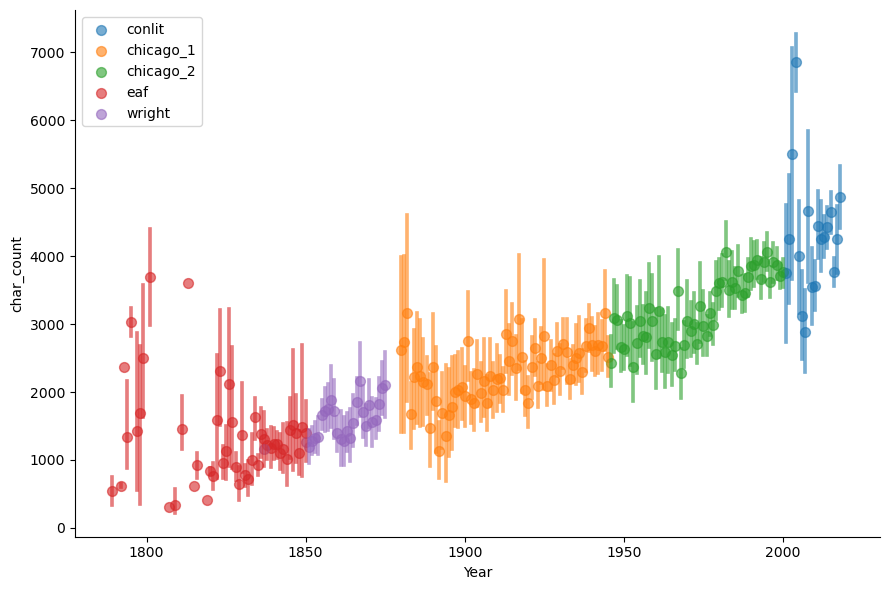

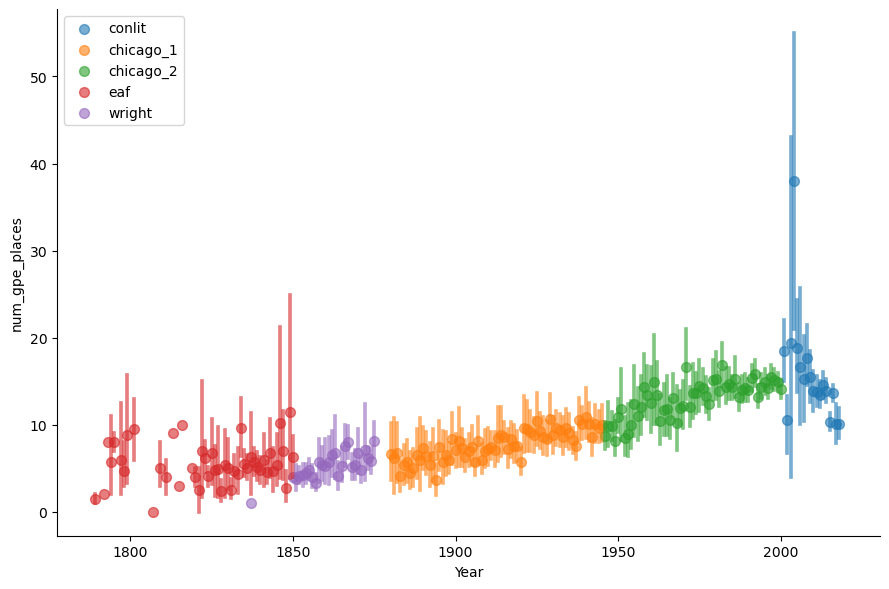

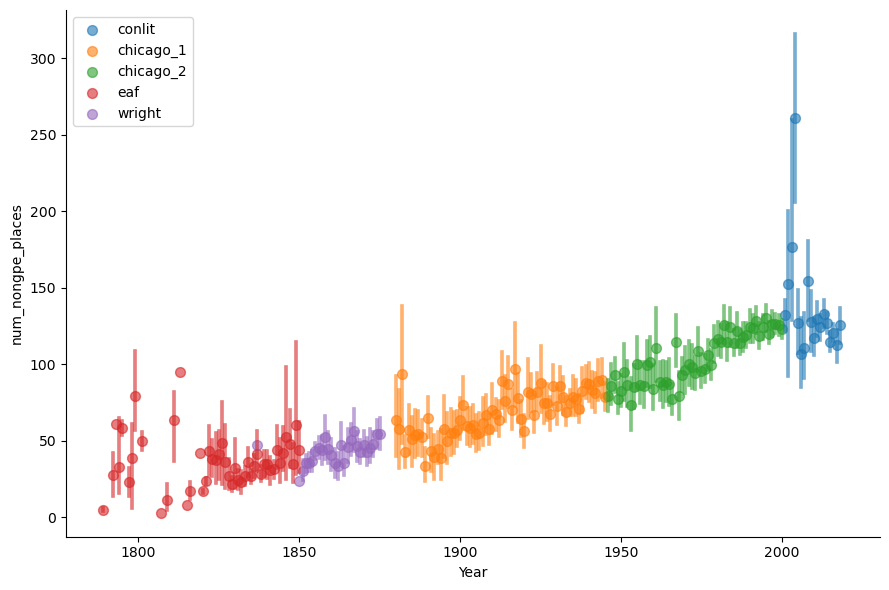

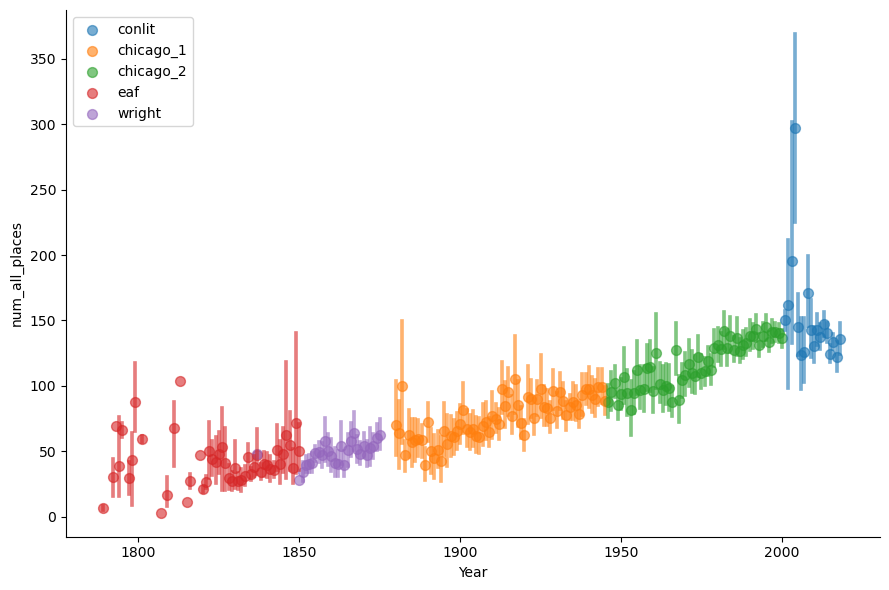

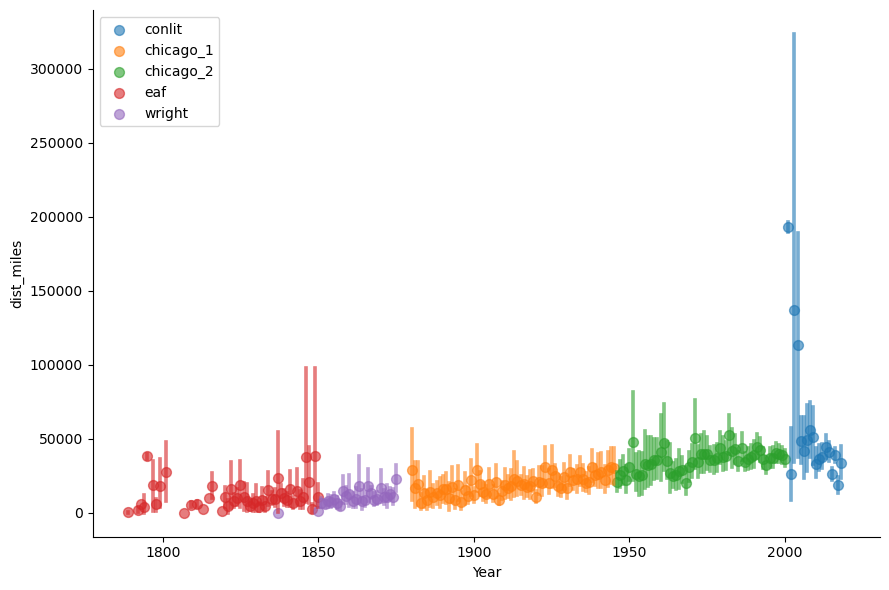

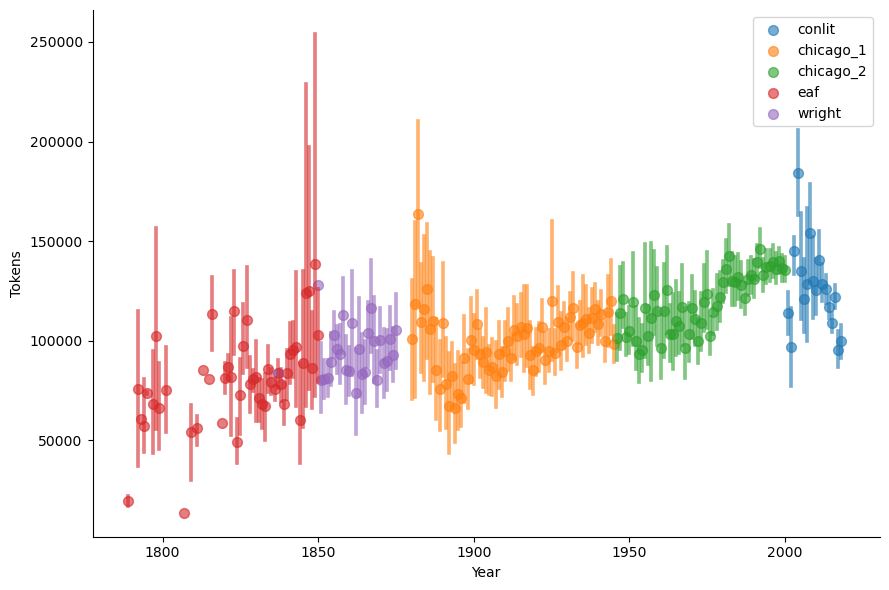

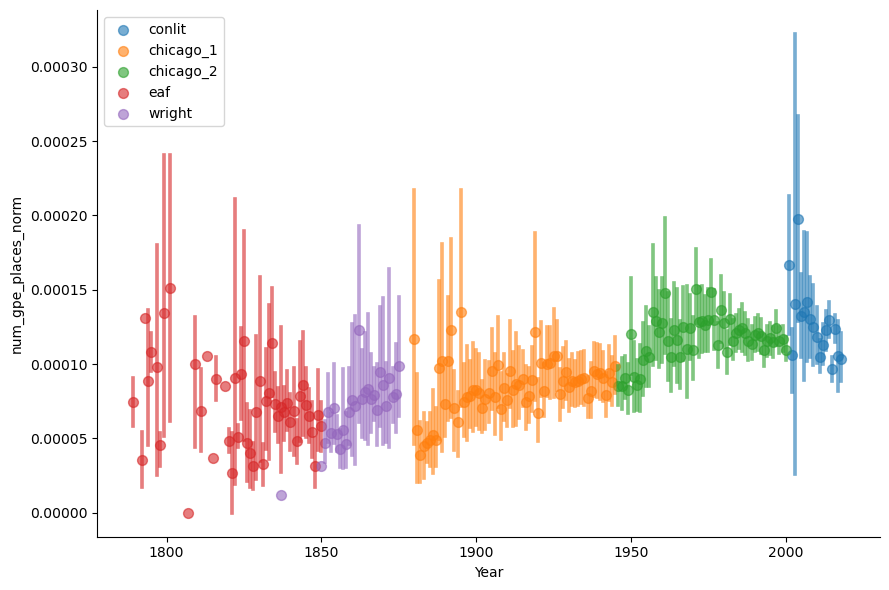

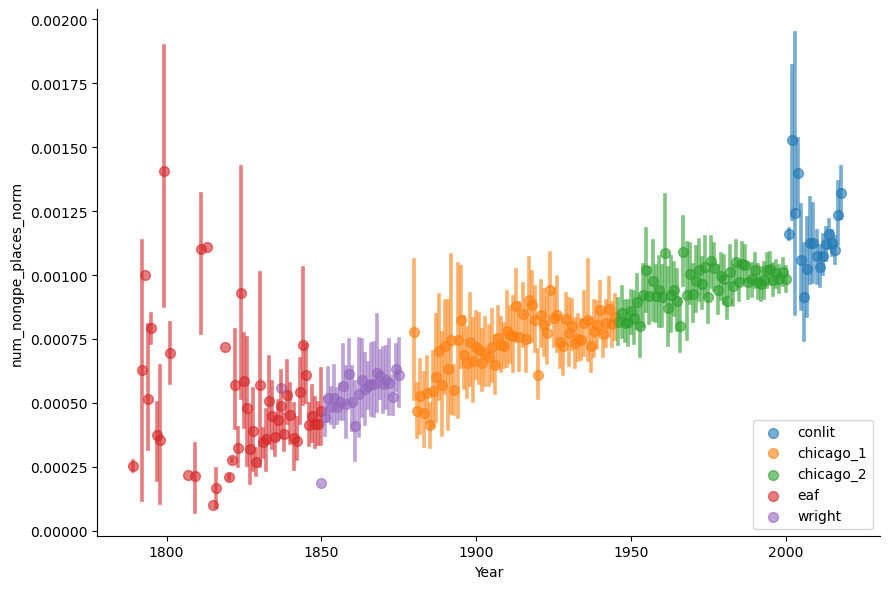

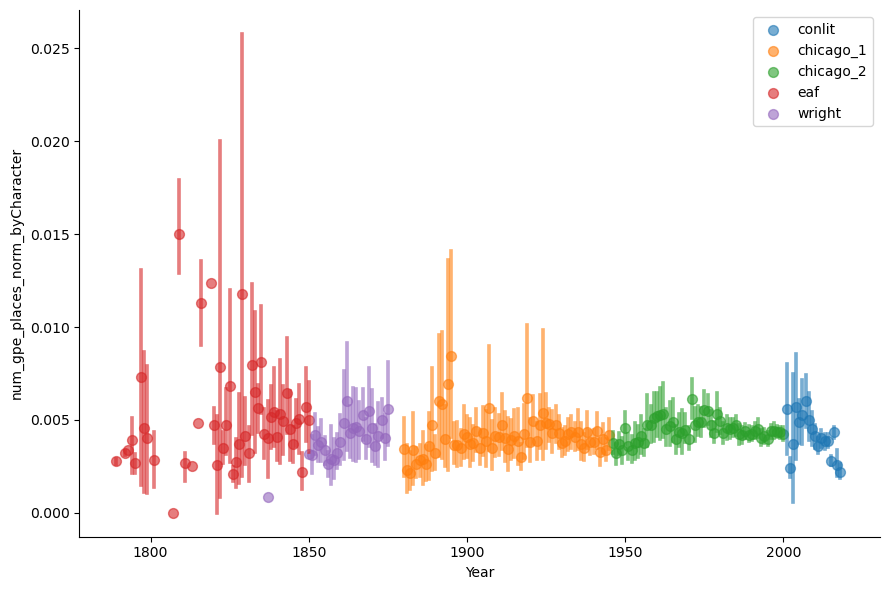

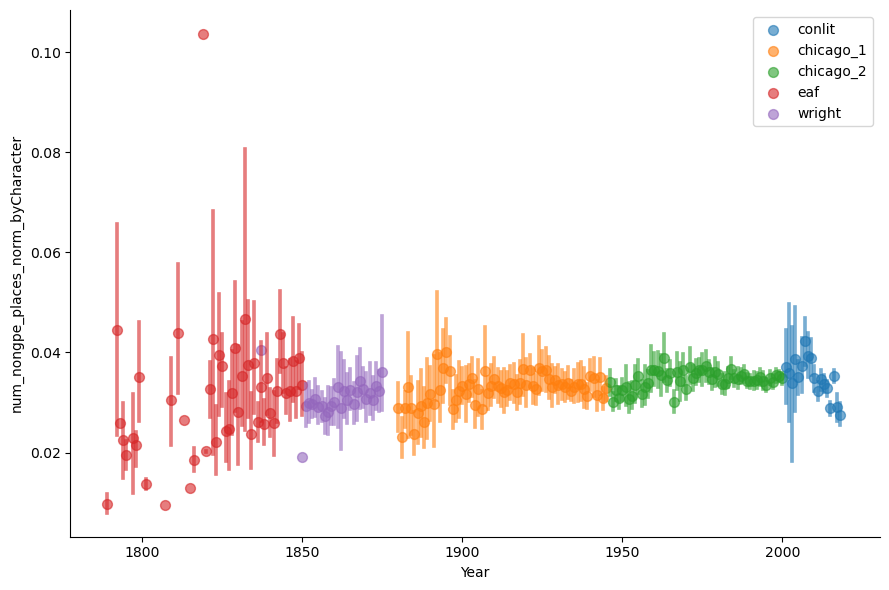

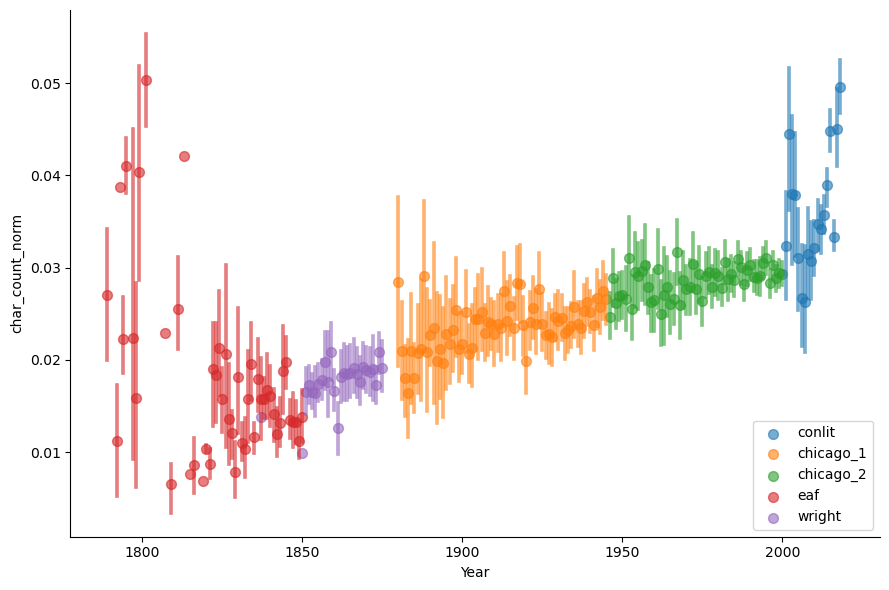

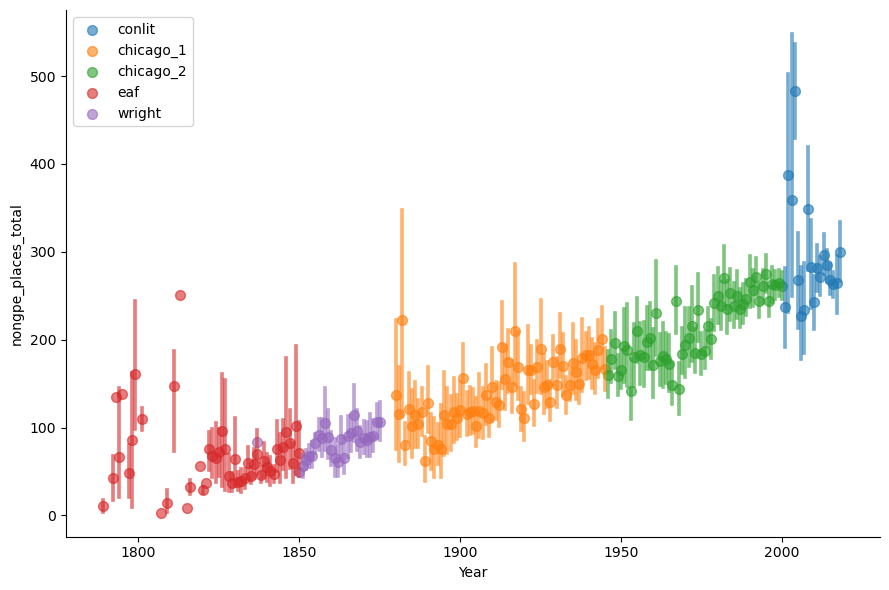

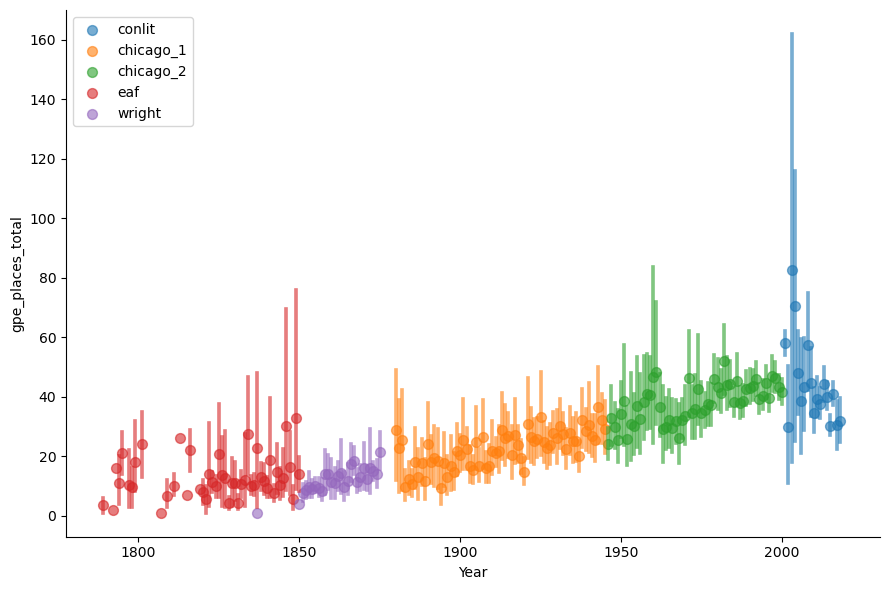

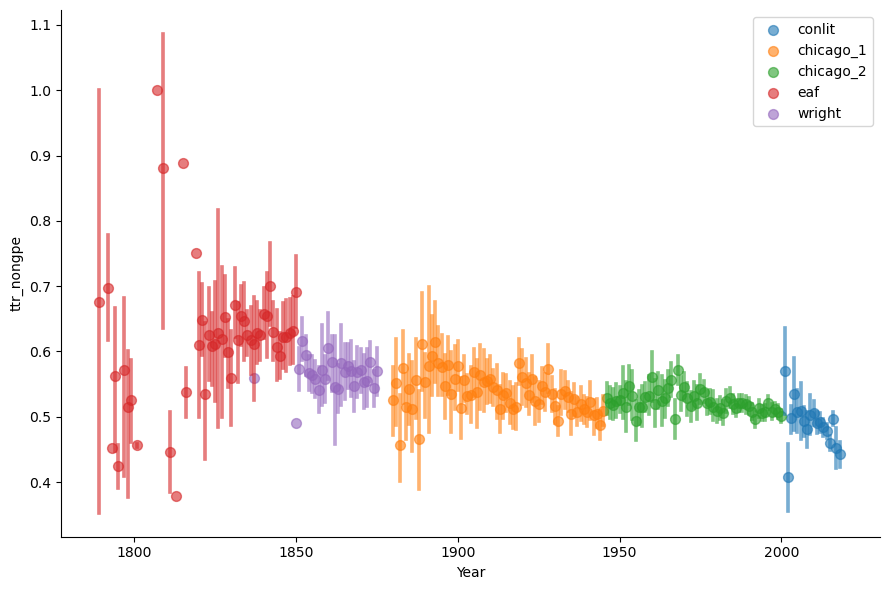

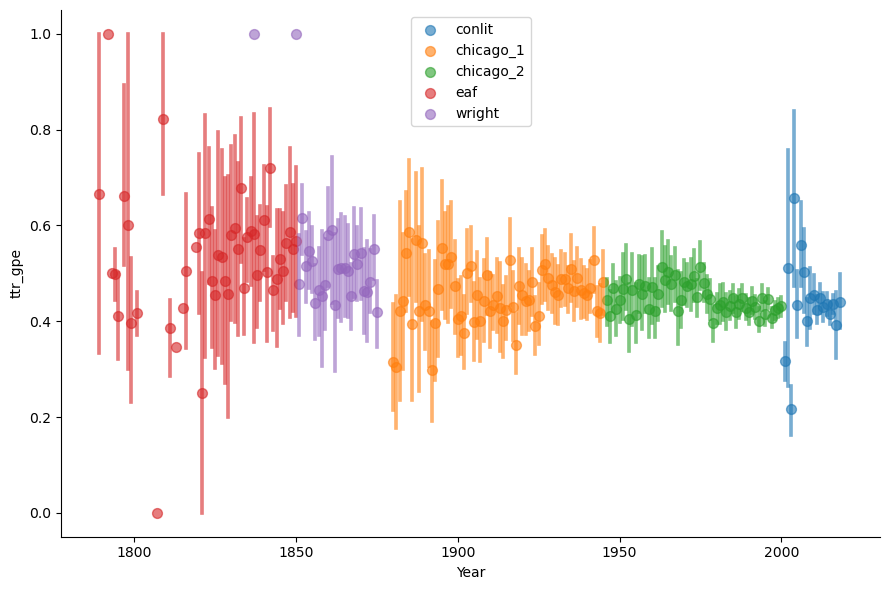

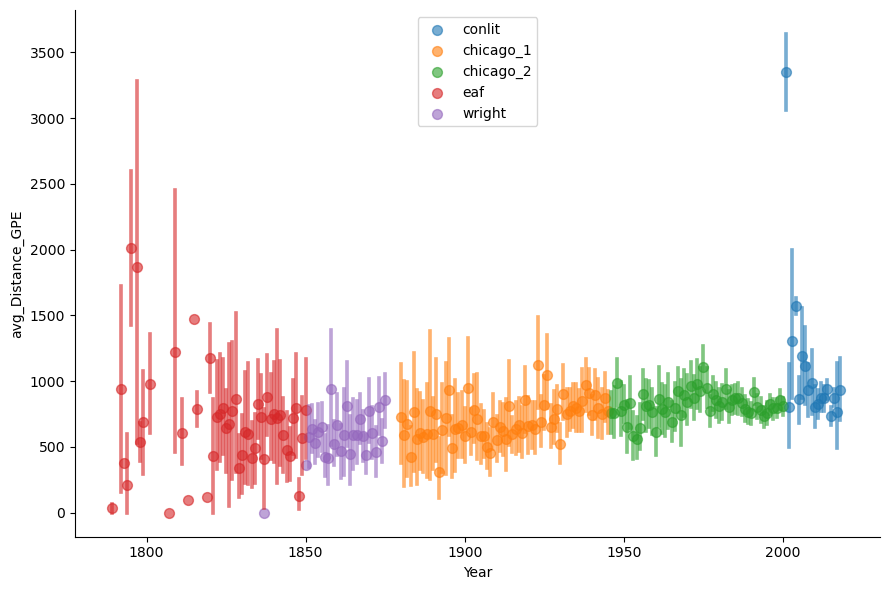

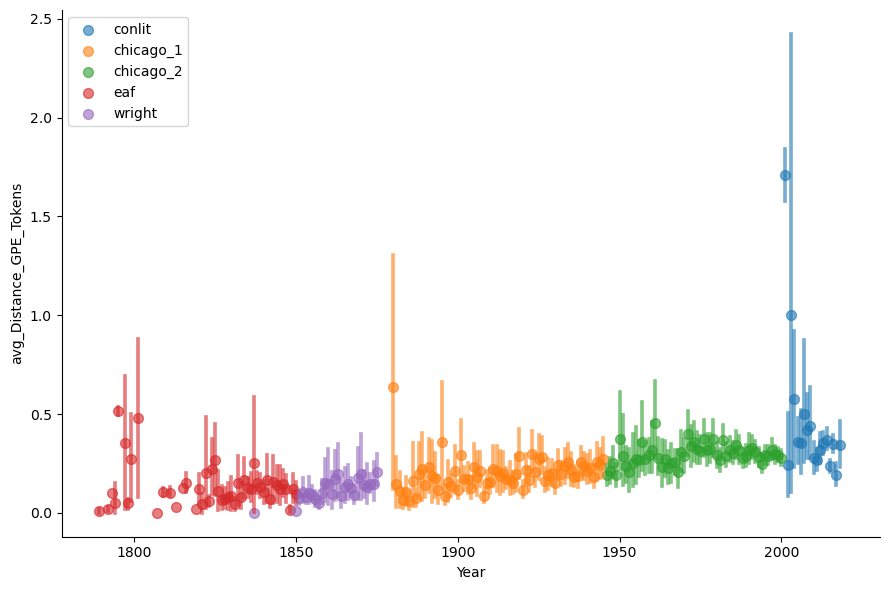

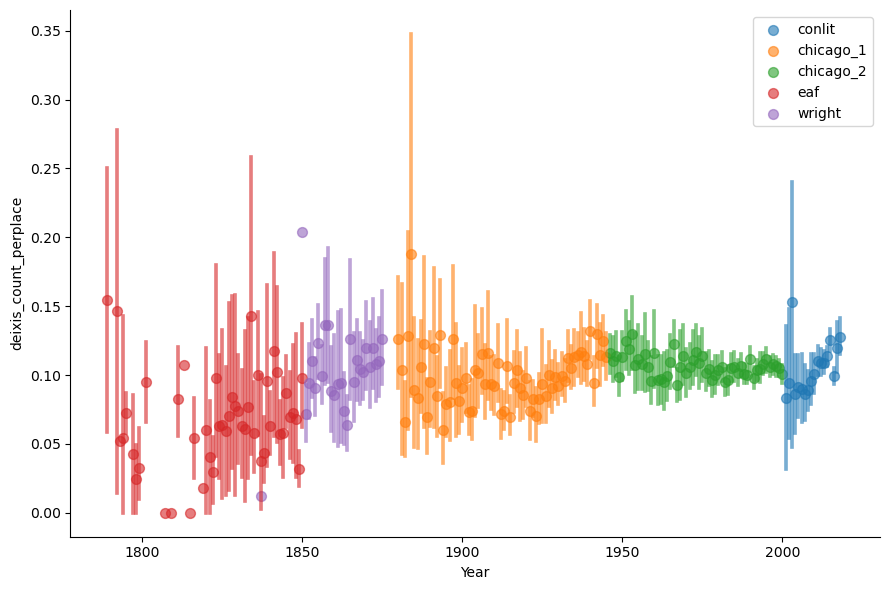

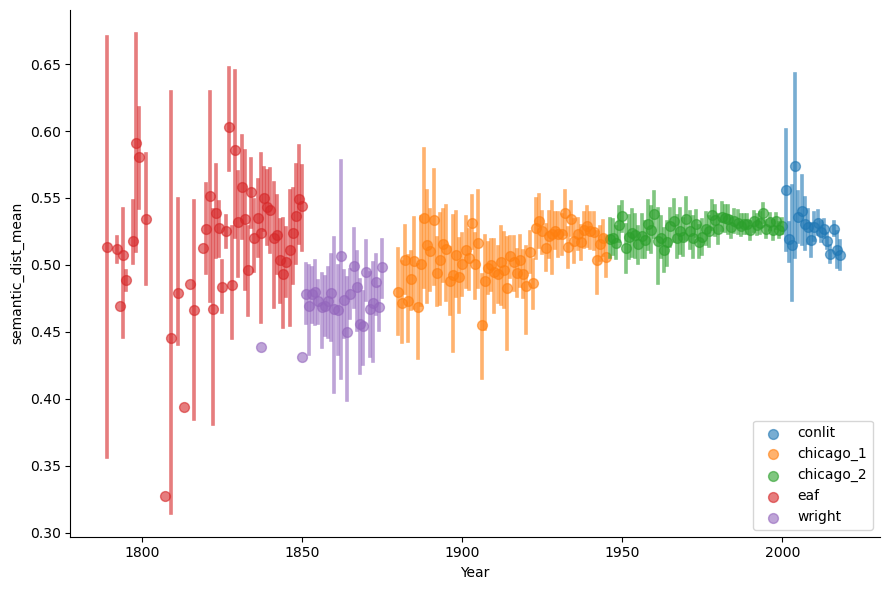

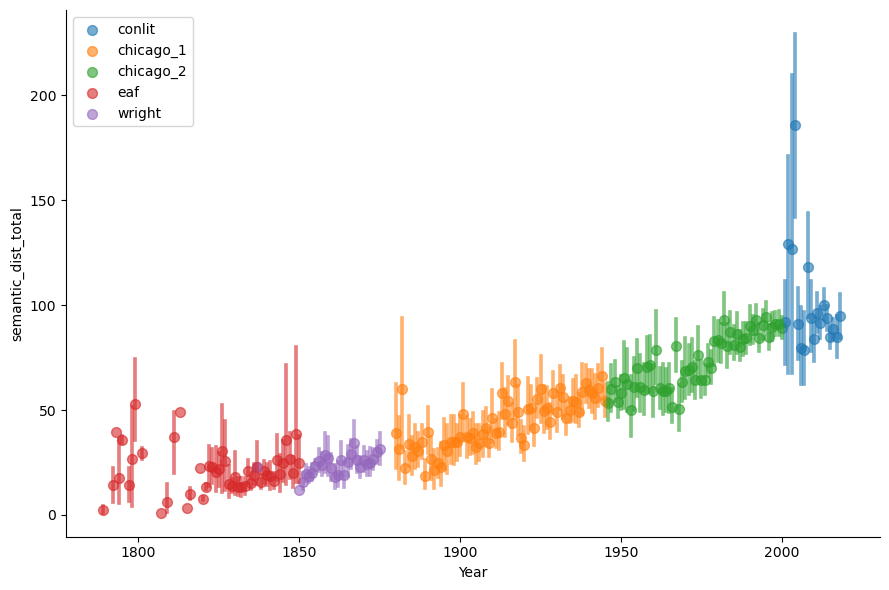

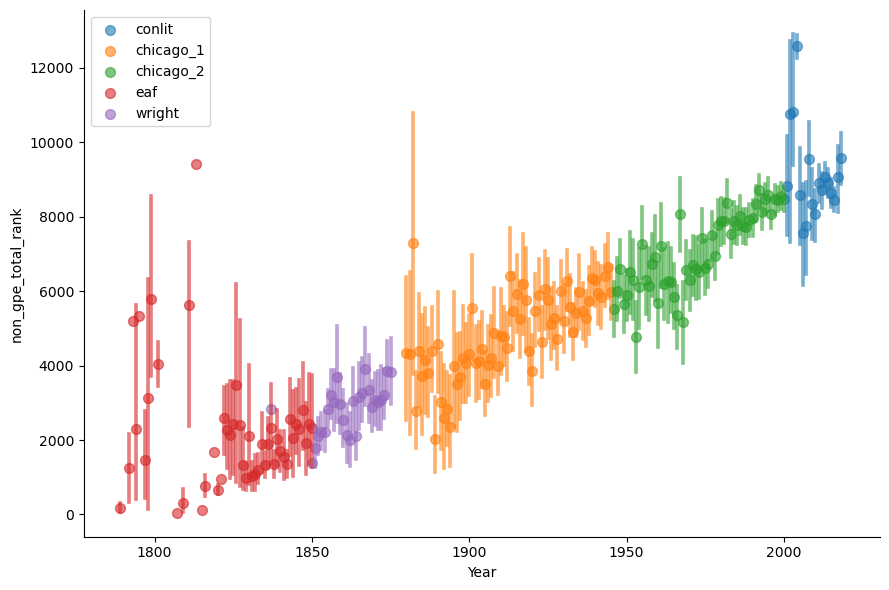

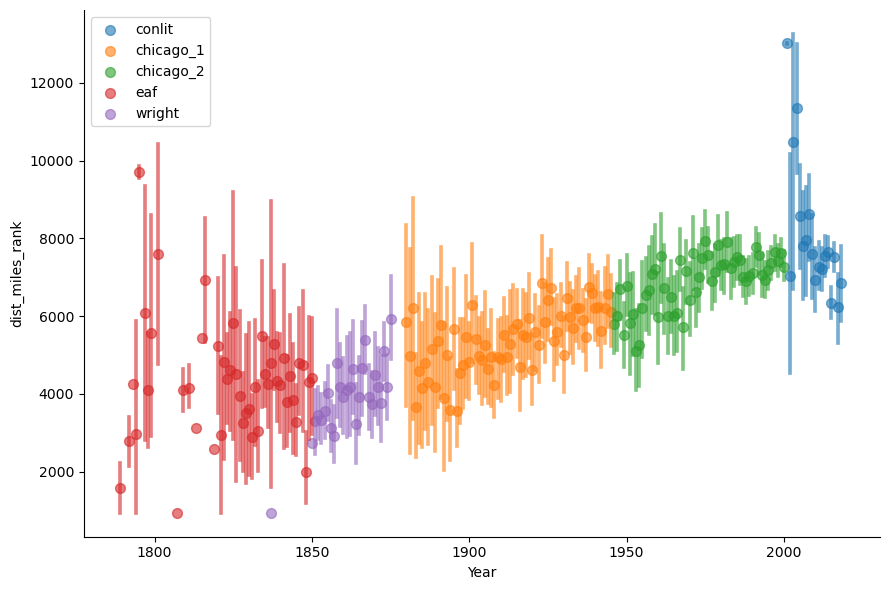

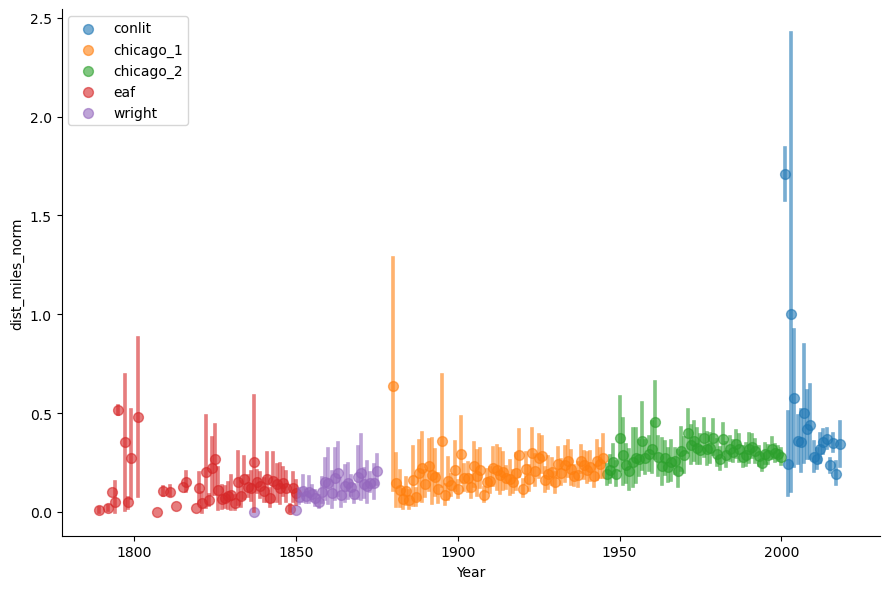

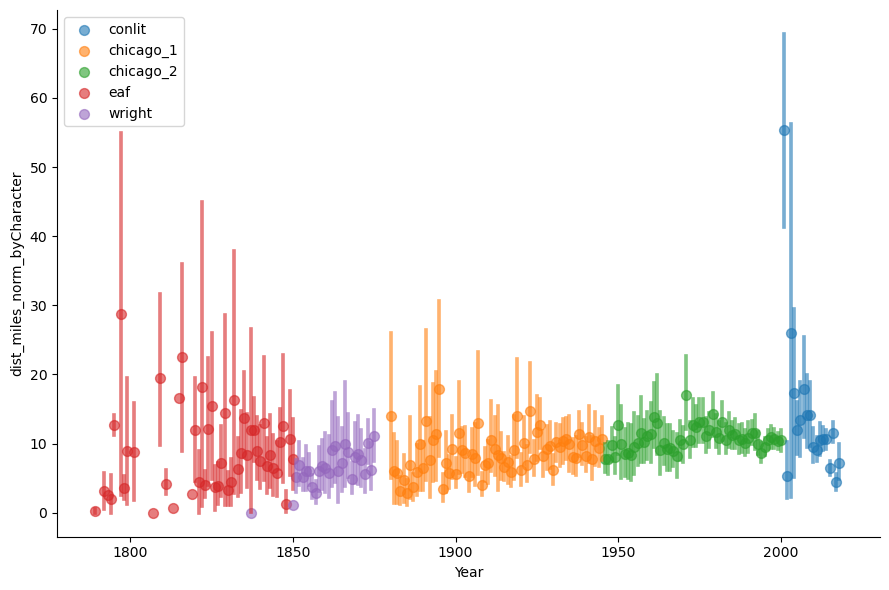

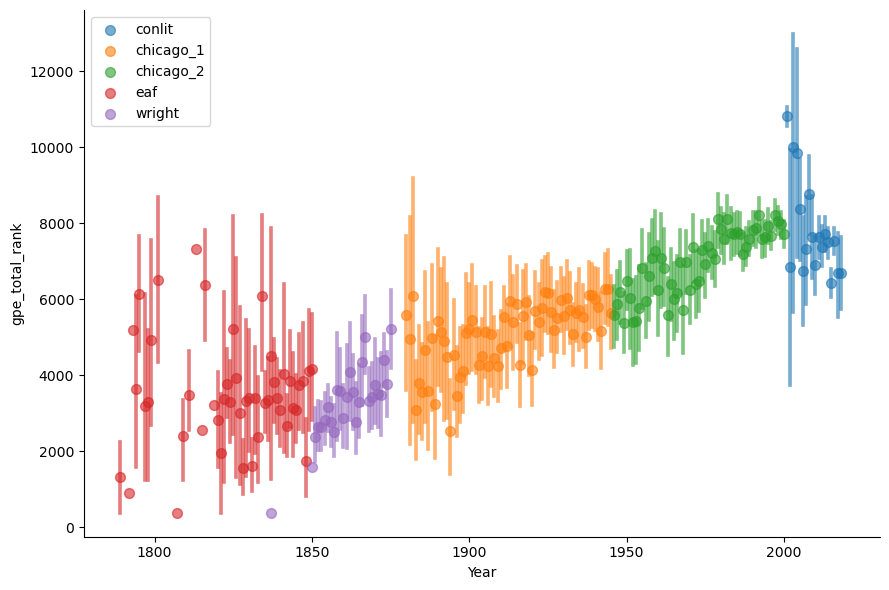

In [8]:
# plot features over time

# restrict to fiction
fic_data = data.loc[data.Category=='FIC']

# use all informative numeric columns
cols_to_drop_from_plot = ['char_id', 'char_rank', 'pub_date']
numeric_cols = fic_data[fic_data.columns[fic_data.notna().all()]].select_dtypes(include='number').drop(columns=cols_to_drop_from_plot).columns

# create plots
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    bins = np.arange(fic_data.pub_date.min(), fic_data.pub_date.max(), 1)
    for col in numeric_cols:
        sns.lmplot(
            x='pub_date', 
            y=col, 
            data=fic_data, 
            #y_partial='Category', # control for fiction/nonfiction
            fit_reg=False,
            x_bins=bins, #fixed total bins by year
            #x_bins=10, # number of bins per collection
            hue='collection',
            legend=False,
            height=6,
            aspect=1.5,
            scatter_kws={'alpha':0.6}
        )
        plt.xlabel('Year')
        plt.ylabel(col)
        plt.legend(loc='best')
        plt.tight_layout()
        plt.show()

### Facet by character gender

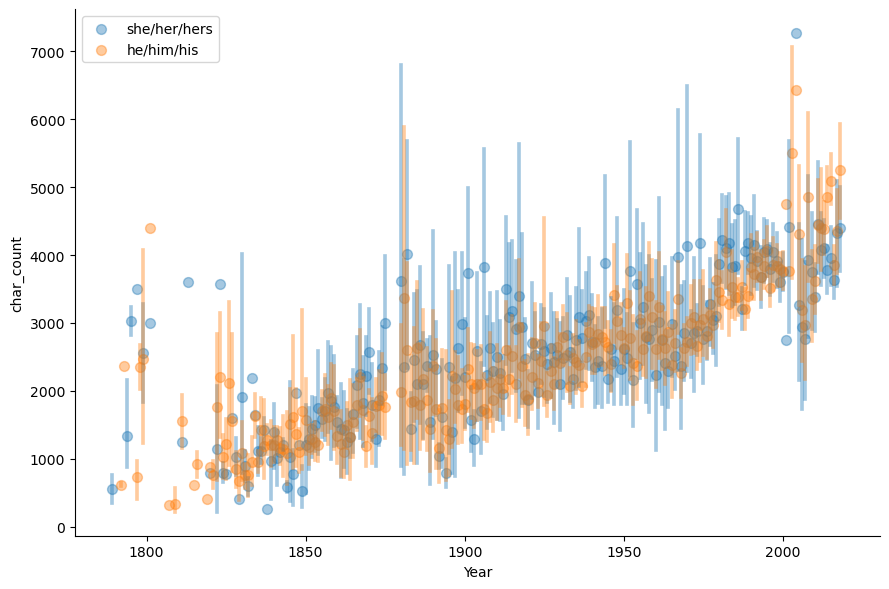

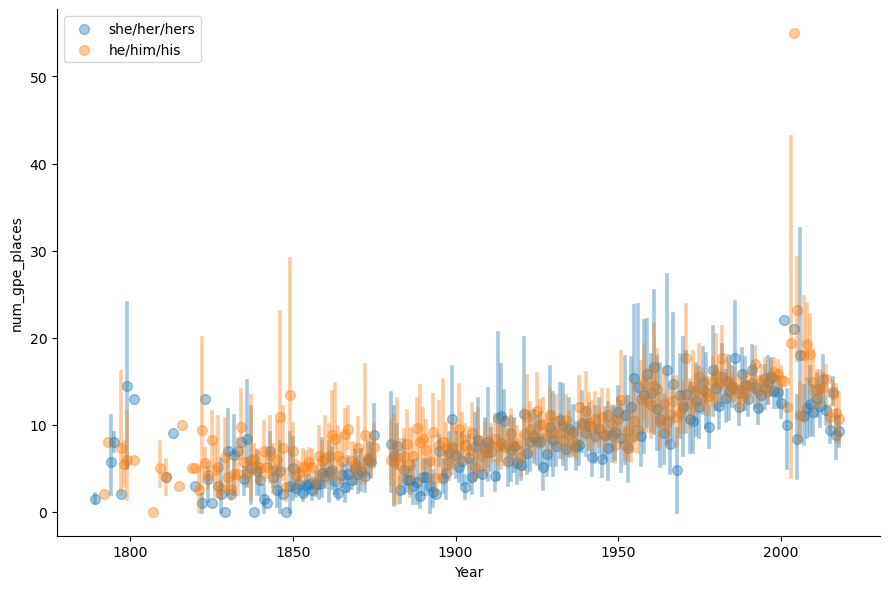

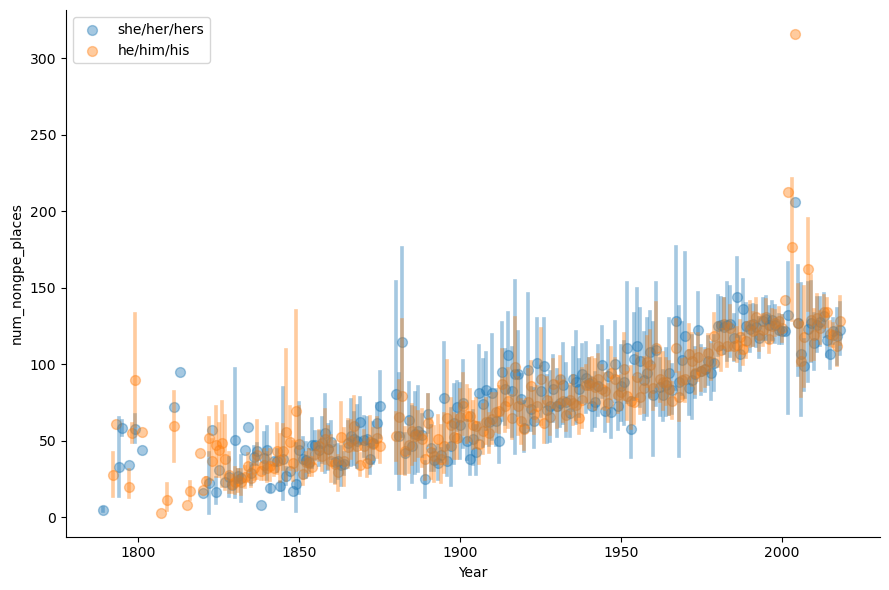

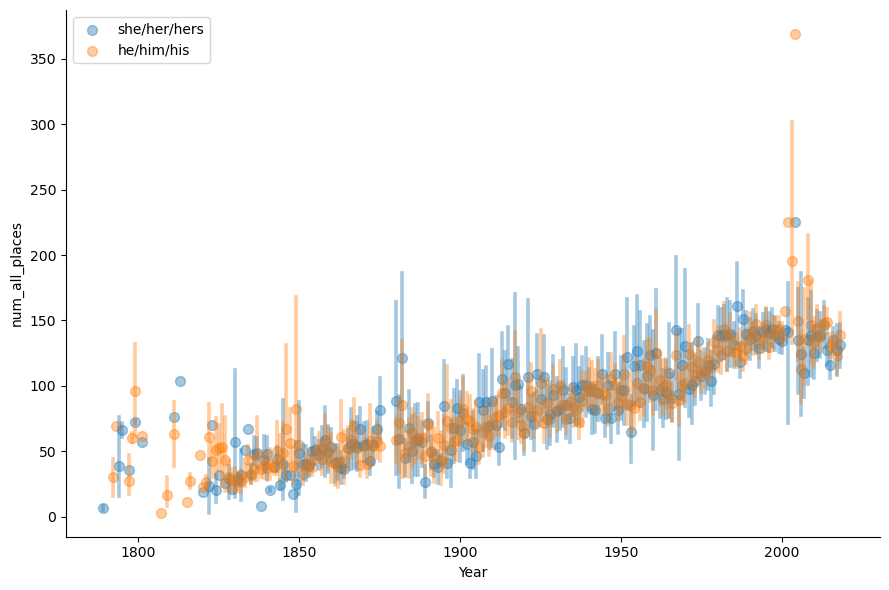

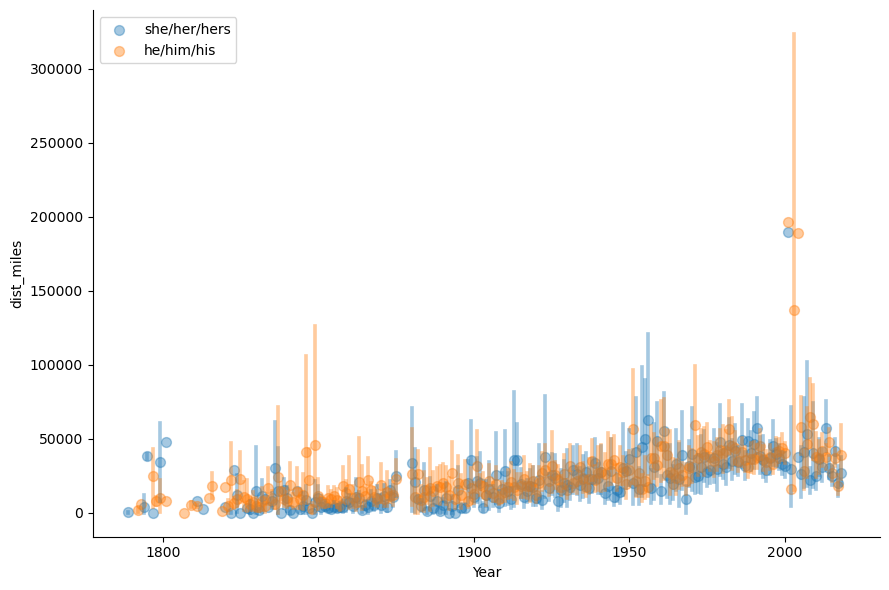

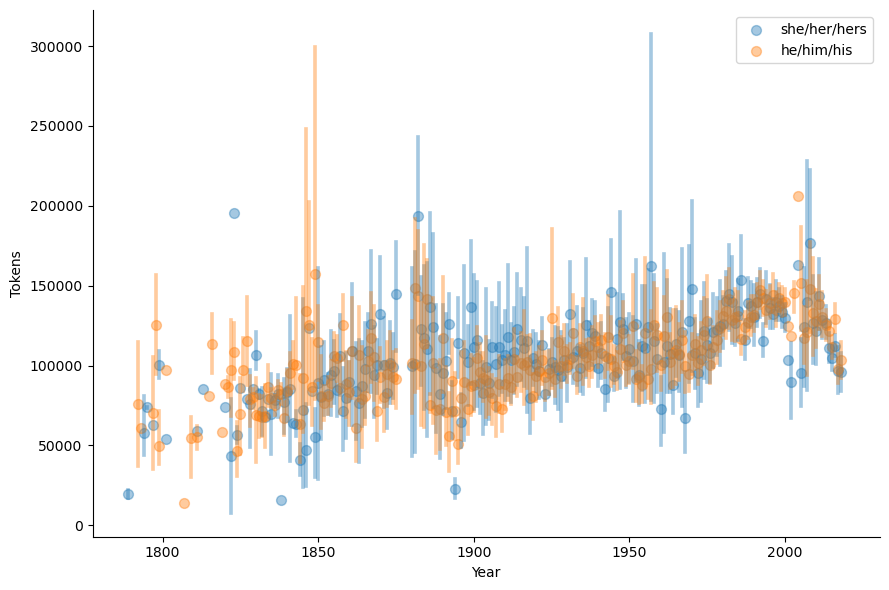

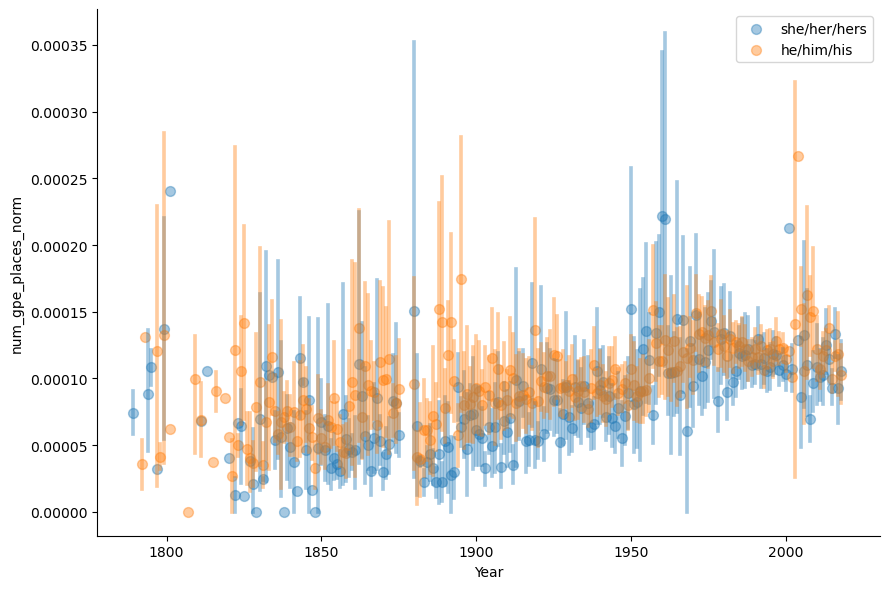

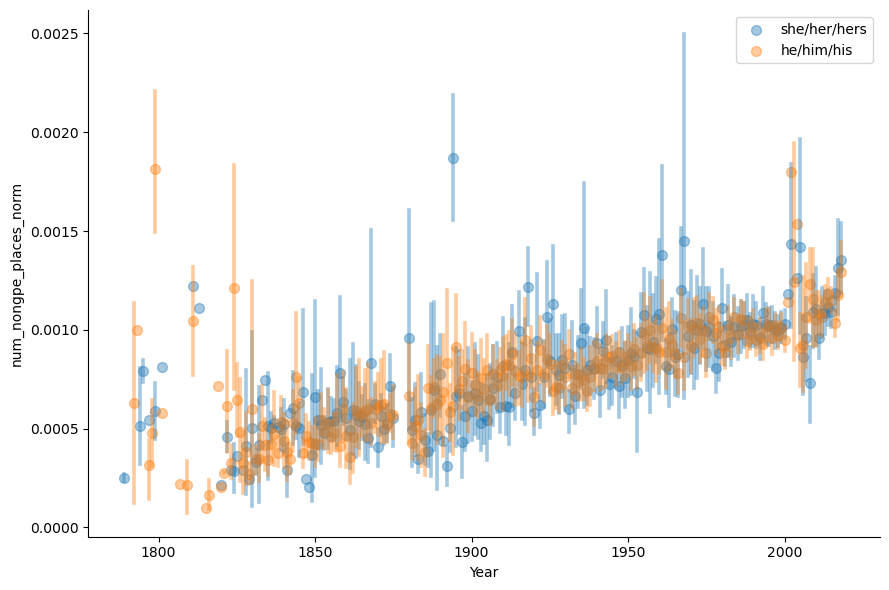

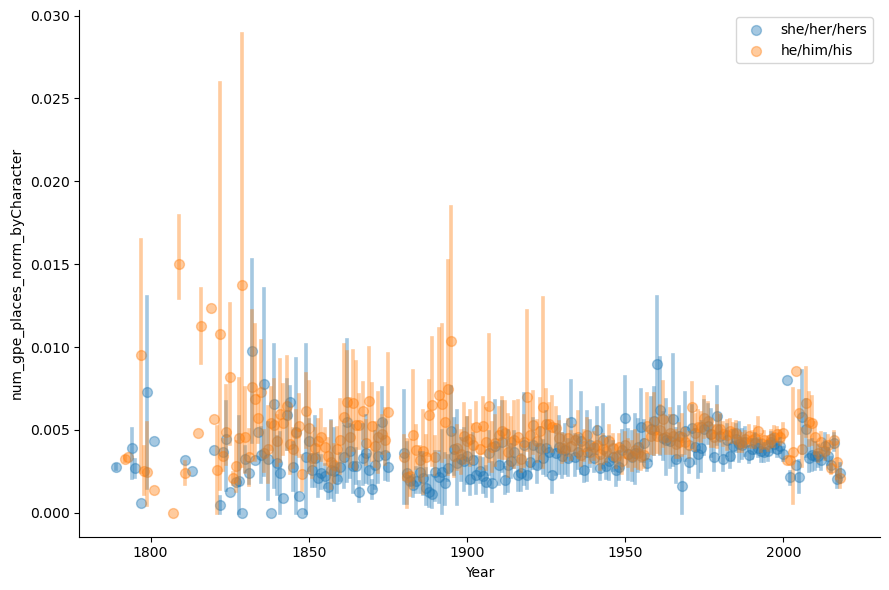

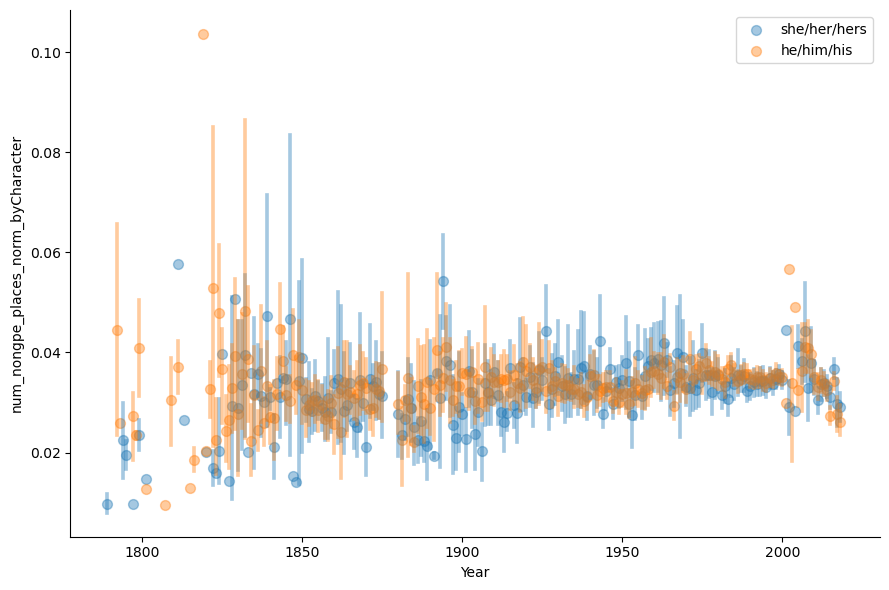

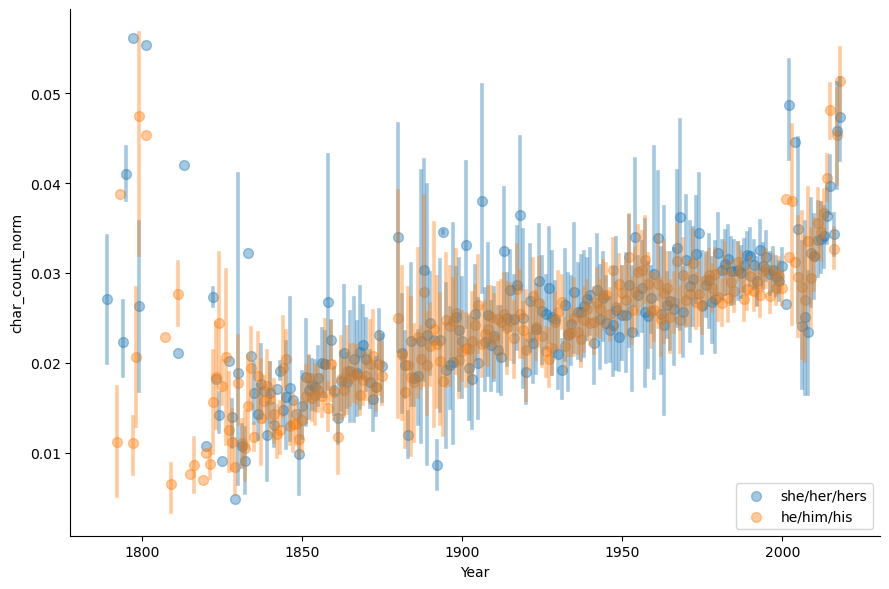

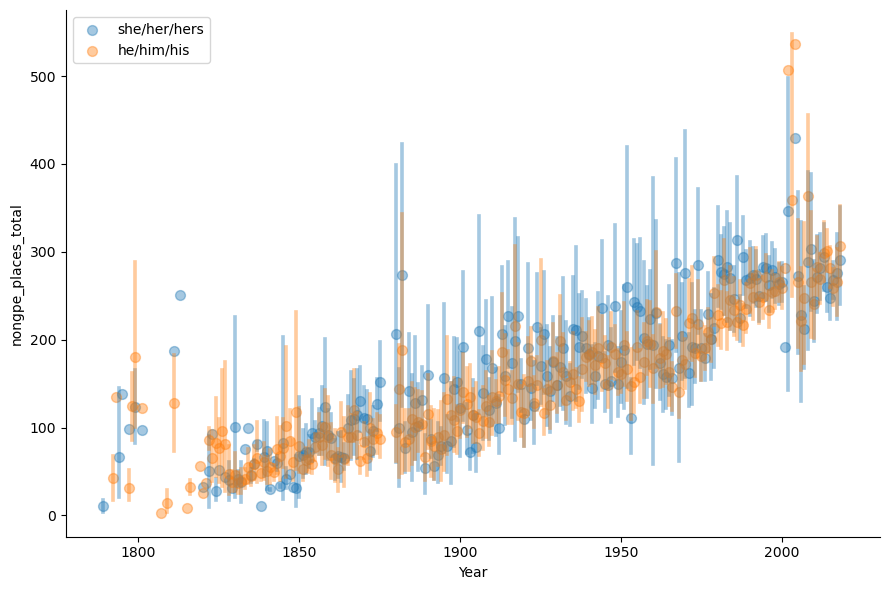

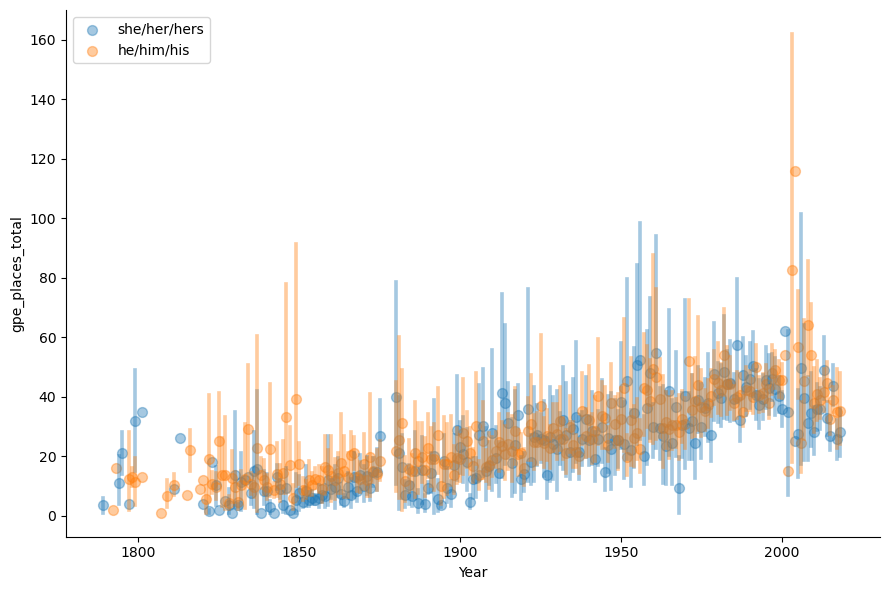

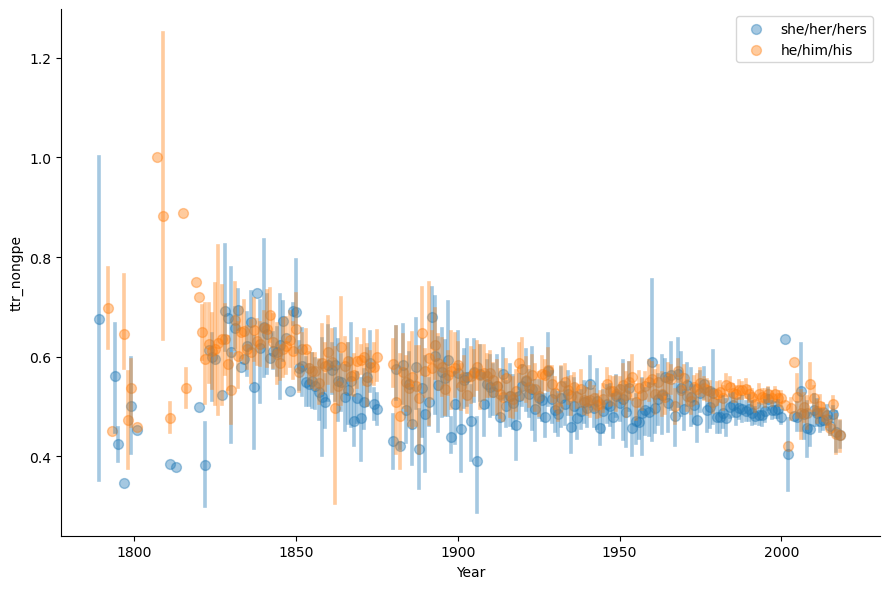

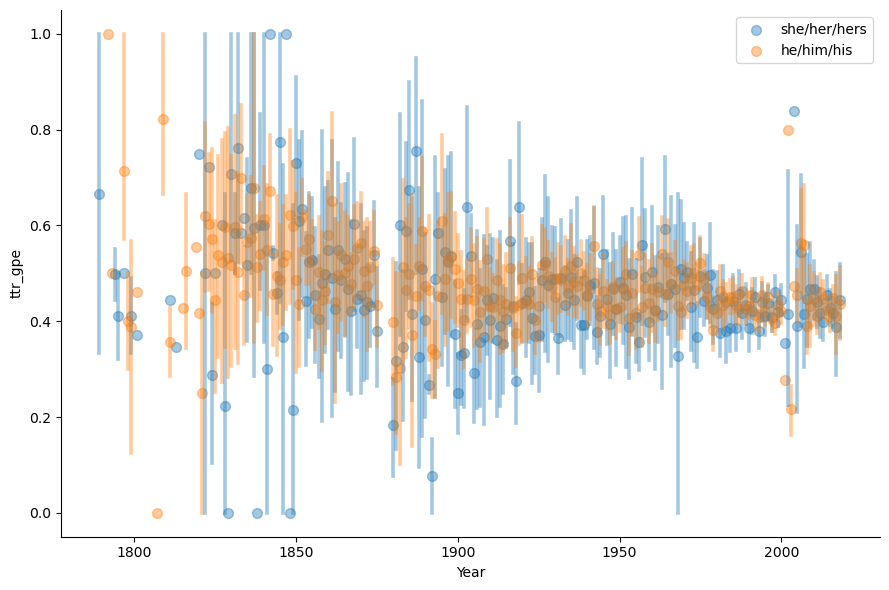

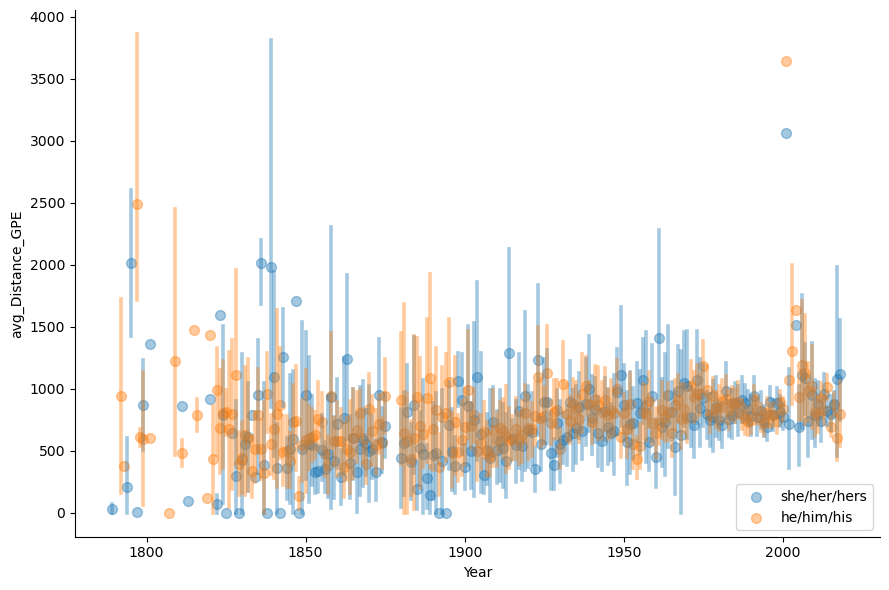

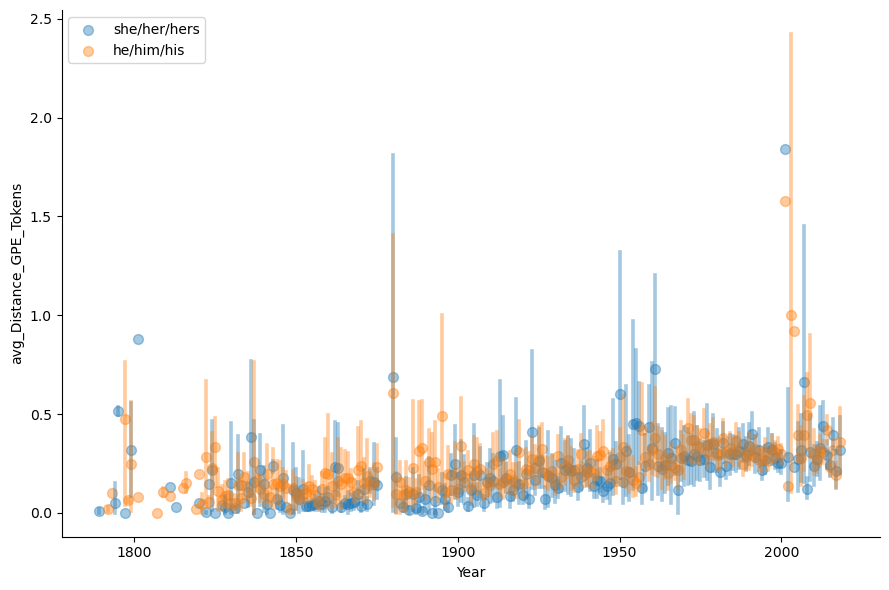

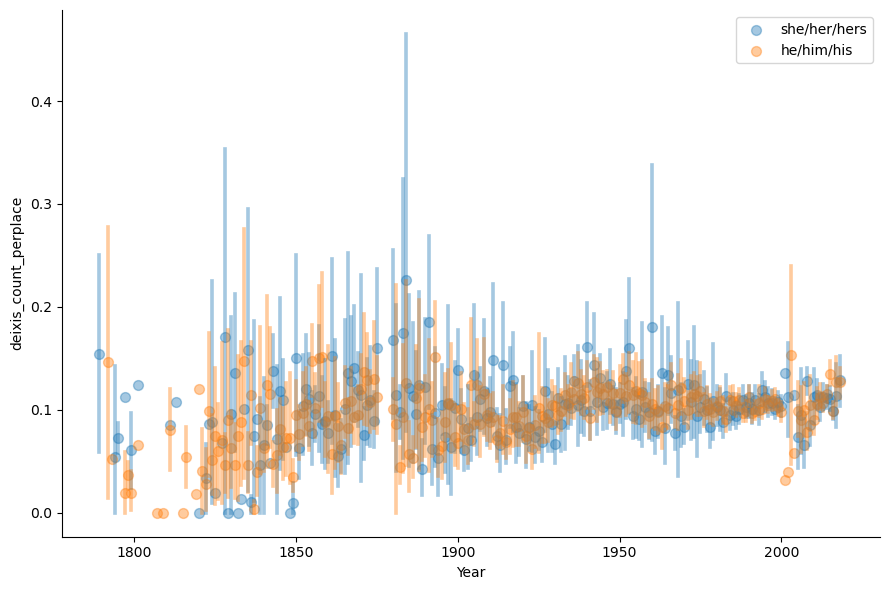

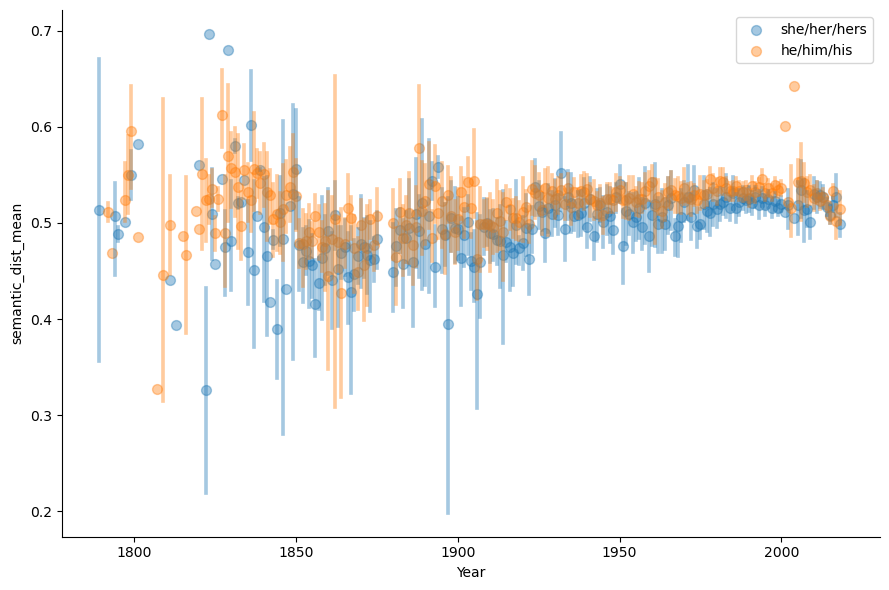

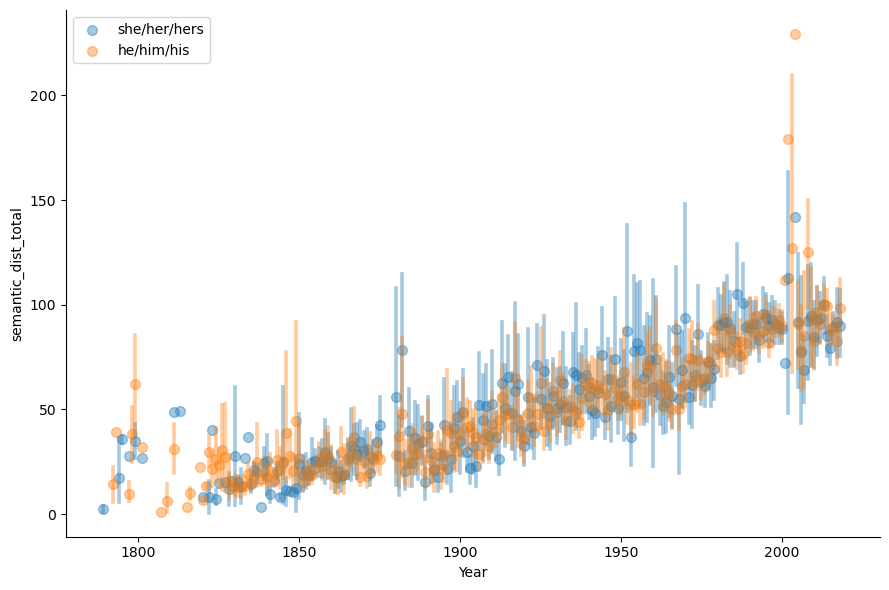

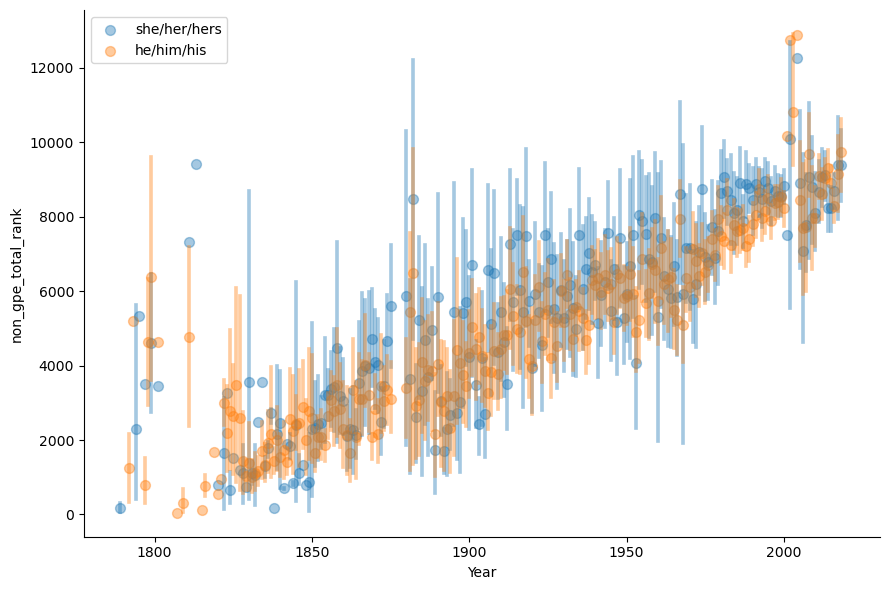

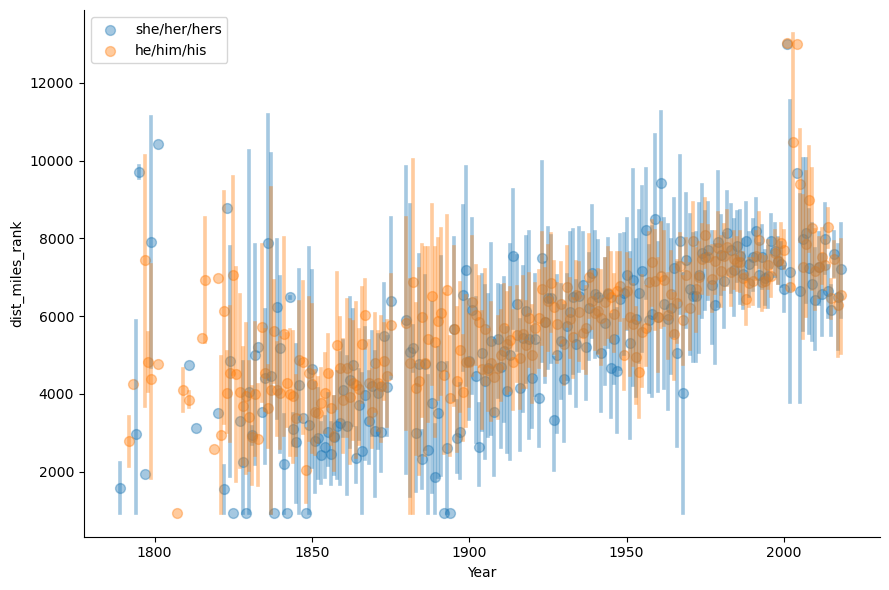

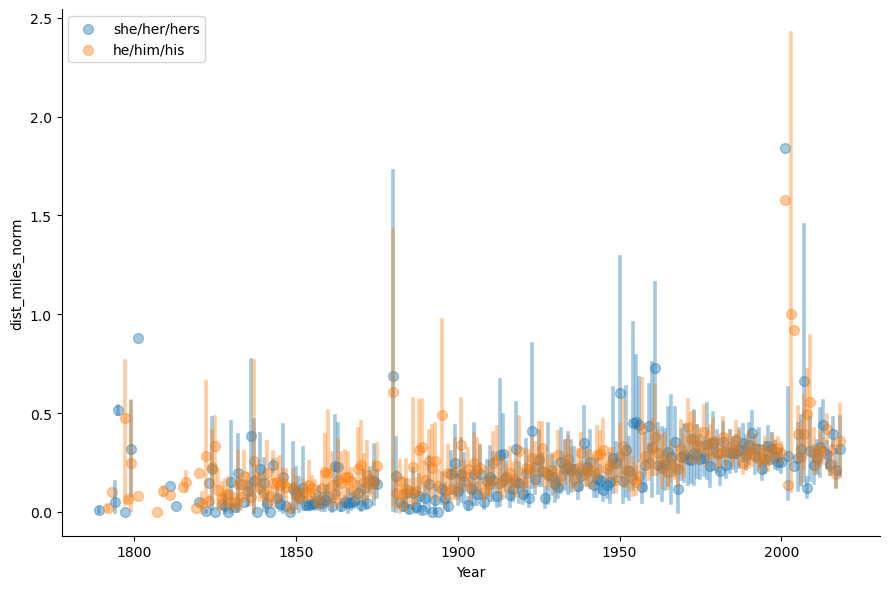

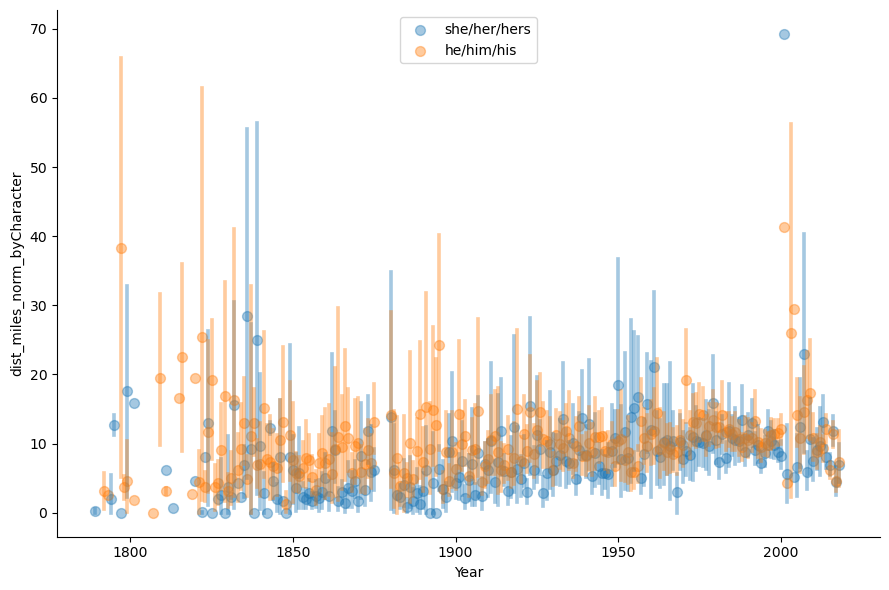

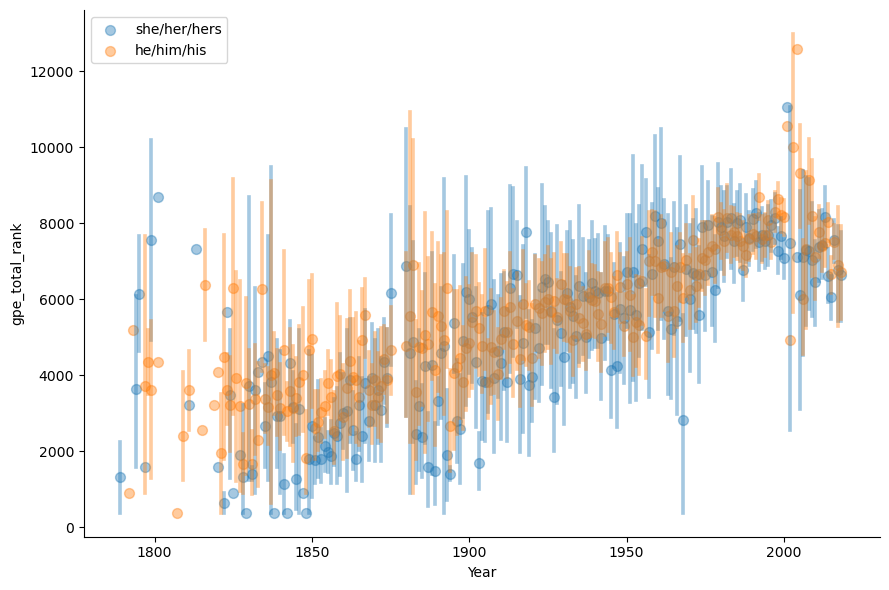

In [9]:
# create plots
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fic_data_gender_limited = fic_data.loc[fic_data.inf_gender.isin(['she/her/hers', 'he/him/his'])]
    bins = np.arange(fic_data.pub_date.min(), fic_data.pub_date.max(), 1)
    for col in numeric_cols:
        sns.lmplot(
            x='pub_date', 
            y=col, 
            data=fic_data_gender_limited, 
            fit_reg=False,
            x_bins=bins, #fixed total bins by year
            hue='inf_gender',
            legend=False,
            height=6,
            aspect=1.5,
            scatter_kws={'alpha':0.4}
        )
        plt.xlabel('Year')
        plt.ylabel(col)
        plt.legend(loc='best')
        plt.tight_layout()
        plt.show()

## Examine specific books and authors

In [30]:
# Read metadata
conlit_meta = pd.read_csv(os.path.join(metadata_dir, conlit_meta_file), index_col='ID').fillna('')
early_meta = pd.read_csv(os.path.join(metadata_dir, early_meta_file), index_col='book_id', sep='\t').fillna('')

In [50]:
# reference points
print("Median distance:", data.dist_miles.median())
print("Median numbers GPEs:", data.num_gpe_places.median())

Median distance: 15731.3846661428
Median numbers GPEs: 9.0


In [37]:
# Tolkien
early_meta.loc[early_meta.author.str.startswith('Tolkien'), ['author', 'title']].join(data[['dist_miles', 'num_gpe_places']])

author       title  dist_miles  num_gpe_places
book_id                                                            
00011059  Tolkien, J. R. R.  The Hobbit         0.0               4

In [36]:
# Any Weir, The Martian
data.loc[data.index.str.contains('TheMartian'), ['dist_miles', 'num_gpe_places']]

dist_miles  num_gpe_places
book_id                                                  
2011_Weir,Andy_TheMartian_SF  9412.553779              16

In [54]:
# Kim Stanley Robinson
display(data.loc[data.index.str.contains('Robinson,Kim'), ['dist_miles', 'num_gpe_places']])
display(early_meta.loc[early_meta.author.str.startswith('Robinson, Kim'), ['author', 'title']].join(data[['dist_miles', 'num_gpe_places']]))

dist_miles  num_gpe_places
book_id                                                         
2012_Robinson,KimStanley_2312_SF    80167.045869              29
2013_Robinson,KimStanley_Shaman_SF      0.000000               1

author                    title    dist_miles  \
book_id                                                                  
00024103  Robinson, Kim Stanley               Green mars  19640.685969   
00023417  Robinson, Kim Stanley             Pacific edge  90421.740009   
00022417  Robinson, Kim Stanley  The memory of whiteness  29284.568645   
00022260  Robinson, Kim Stanley           The Wild Shore  51666.671513   
00022956  Robinson, Kim Stanley           The Gold Coast  91512.217820   
00023180  Robinson, Kim Stanley    Escape from Kathmandu  45137.422620   
00024406  Robinson, Kim Stanley                Blue Mars  57549.459250   
00023967  Robinson, Kim Stanley                 Red Mars  26193.381240   

          num_gpe_places  
book_id                   
00024103              24  
00023417              19  
00022417              16  
00022260              21  
00022956              22  
00023180              23  
00024406              26  
00023967              18

In [56]:
# George R. R. Martin
display(early_meta.loc[early_meta.author.str.startswith('Martin, George R'), ['author', 'title']].join(data[['dist_miles', 'num_gpe_places']]))
display(data.loc[data.index.str.contains('Martin,George'), ['dist_miles', 'num_gpe_places']])

author               title     dist_miles  \
book_id                                                            
00024931  Martin, George R. R    A clash of kings       0.000000   
00022101  Martin, George R. R  The Armageddon rag  103221.908609   
00024359  Martin, George R. R   A game of thrones       0.000000   
00021862  Martin, George R. R           Windhaven     666.305945   
00021989  Martin, George R. R         Fevre dream   58895.552655   
00021448  Martin, George R. R  Dying of the light   35423.305181   
00022541  Martin, George R. R        Tuf voyaging    4962.360649   

          num_gpe_places  
book_id                   
00024931              10  
00022101              36  
00024359               4  
00021862              25  
00021989              26  
00021448              15  
00022541              12

dist_miles  num_gpe_places
book_id                                                            
2011_Martin,George_ADancewithDragons_BS         0.0              12